In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec 15 13:40:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
class_idx_to_name = {"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829", "house_finch"], "13": ["n01534433", "junco"], "14": ["n01537544", "indigo_bunting"], "15": ["n01558993", "robin"], "16": ["n01560419", "bulbul"], "17": ["n01580077", "jay"], "18": ["n01582220", "magpie"], "19": ["n01592084", "chickadee"], "20": ["n01601694", "water_ouzel"], "21": ["n01608432", "kite"], "22": ["n01614925", "bald_eagle"], "23": ["n01616318", "vulture"], "24": ["n01622779", "great_grey_owl"], "25": ["n01629819", "European_fire_salamander"], "26": ["n01630670", "common_newt"], "27": ["n01631663", "eft"], "28": ["n01632458", "spotted_salamander"], "29": ["n01632777", "axolotl"], "30": ["n01641577", "bullfrog"], "31": ["n01644373", "tree_frog"], "32": ["n01644900", "tailed_frog"], "33": ["n01664065", "loggerhead"], "34": ["n01665541", "leatherback_turtle"], "35": ["n01667114", "mud_turtle"], "36": ["n01667778", "terrapin"], "37": ["n01669191", "box_turtle"], "38": ["n01675722", "banded_gecko"], "39": ["n01677366", "common_iguana"], "40": ["n01682714", "American_chameleon"], "41": ["n01685808", "whiptail"], "42": ["n01687978", "agama"], "43": ["n01688243", "frilled_lizard"], "44": ["n01689811", "alligator_lizard"], "45": ["n01692333", "Gila_monster"], "46": ["n01693334", "green_lizard"], "47": ["n01694178", "African_chameleon"], "48": ["n01695060", "Komodo_dragon"], "49": ["n01697457", "African_crocodile"], "50": ["n01698640", "American_alligator"], "51": ["n01704323", "triceratops"], "52": ["n01728572", "thunder_snake"], "53": ["n01728920", "ringneck_snake"], "54": ["n01729322", "hognose_snake"], "55": ["n01729977", "green_snake"], "56": ["n01734418", "king_snake"], "57": ["n01735189", "garter_snake"], "58": ["n01737021", "water_snake"], "59": ["n01739381", "vine_snake"], "60": ["n01740131", "night_snake"], "61": ["n01742172", "boa_constrictor"], "62": ["n01744401", "rock_python"], "63": ["n01748264", "Indian_cobra"], "64": ["n01749939", "green_mamba"], "65": ["n01751748", "sea_snake"], "66": ["n01753488", "horned_viper"], "67": ["n01755581", "diamondback"], "68": ["n01756291", "sidewinder"], "69": ["n01768244", "trilobite"], "70": ["n01770081", "harvestman"], "71": ["n01770393", "scorpion"], "72": ["n01773157", "black_and_gold_garden_spider"], "73": ["n01773549", "barn_spider"], "74": ["n01773797", "garden_spider"], "75": ["n01774384", "black_widow"], "76": ["n01774750", "tarantula"], "77": ["n01775062", "wolf_spider"], "78": ["n01776313", "tick"], "79": ["n01784675", "centipede"], "80": ["n01795545", "black_grouse"], "81": ["n01796340", "ptarmigan"], "82": ["n01797886", "ruffed_grouse"], "83": ["n01798484", "prairie_chicken"], "84": ["n01806143", "peacock"], "85": ["n01806567", "quail"], "86": ["n01807496", "partridge"], "87": ["n01817953", "African_grey"], "88": ["n01818515", "macaw"], "89": ["n01819313", "sulphur-crested_cockatoo"], "90": ["n01820546", "lorikeet"], "91": ["n01824575", "coucal"], "92": ["n01828970", "bee_eater"], "93": ["n01829413", "hornbill"], "94": ["n01833805", "hummingbird"], "95": ["n01843065", "jacamar"], "96": ["n01843383", "toucan"], "97": ["n01847000", "drake"], "98": ["n01855032", "red-breasted_merganser"], "99": ["n01855672", "goose"], "100": ["n01860187", "black_swan"], "101": ["n01871265", "tusker"], "102": ["n01872401", "echidna"], "103": ["n01873310", "platypus"], "104": ["n01877812", "wallaby"], "105": ["n01882714", "koala"], "106": ["n01883070", "wombat"], "107": ["n01910747", "jellyfish"], "108": ["n01914609", "sea_anemone"], "109": ["n01917289", "brain_coral"], "110": ["n01924916", "flatworm"], "111": ["n01930112", "nematode"], "112": ["n01943899", "conch"], "113": ["n01944390", "snail"], "114": ["n01945685", "slug"], "115": ["n01950731", "sea_slug"], "116": ["n01955084", "chiton"], "117": ["n01968897", "chambered_nautilus"], "118": ["n01978287", "Dungeness_crab"], "119": ["n01978455", "rock_crab"], "120": ["n01980166", "fiddler_crab"], "121": ["n01981276", "king_crab"], "122": ["n01983481", "American_lobster"], "123": ["n01984695", "spiny_lobster"], "124": ["n01985128", "crayfish"], "125": ["n01986214", "hermit_crab"], "126": ["n01990800", "isopod"], "127": ["n02002556", "white_stork"], "128": ["n02002724", "black_stork"], "129": ["n02006656", "spoonbill"], "130": ["n02007558", "flamingo"], "131": ["n02009229", "little_blue_heron"], "132": ["n02009912", "American_egret"], "133": ["n02011460", "bittern"], "134": ["n02012849", "crane"], "135": ["n02013706", "limpkin"], "136": ["n02017213", "European_gallinule"], "137": ["n02018207", "American_coot"], "138": ["n02018795", "bustard"], "139": ["n02025239", "ruddy_turnstone"], "140": ["n02027492", "red-backed_sandpiper"], "141": ["n02028035", "redshank"], "142": ["n02033041", "dowitcher"], "143": ["n02037110", "oystercatcher"], "144": ["n02051845", "pelican"], "145": ["n02056570", "king_penguin"], "146": ["n02058221", "albatross"], "147": ["n02066245", "grey_whale"], "148": ["n02071294", "killer_whale"], "149": ["n02074367", "dugong"], "150": ["n02077923", "sea_lion"], "151": ["n02085620", "Chihuahua"], "152": ["n02085782", "Japanese_spaniel"], "153": ["n02085936", "Maltese_dog"], "154": ["n02086079", "Pekinese"], "155": ["n02086240", "Shih-Tzu"], "156": ["n02086646", "Blenheim_spaniel"], "157": ["n02086910", "papillon"], "158": ["n02087046", "toy_terrier"], "159": ["n02087394", "Rhodesian_ridgeback"], "160": ["n02088094", "Afghan_hound"], "161": ["n02088238", "basset"], "162": ["n02088364", "beagle"], "163": ["n02088466", "bloodhound"], "164": ["n02088632", "bluetick"], "165": ["n02089078", "black-and-tan_coonhound"], "166": ["n02089867", "Walker_hound"], "167": ["n02089973", "English_foxhound"], "168": ["n02090379", "redbone"], "169": ["n02090622", "borzoi"], "170": ["n02090721", "Irish_wolfhound"], "171": ["n02091032", "Italian_greyhound"], "172": ["n02091134", "whippet"], "173": ["n02091244", "Ibizan_hound"], "174": ["n02091467", "Norwegian_elkhound"], "175": ["n02091635", "otterhound"], "176": ["n02091831", "Saluki"], "177": ["n02092002", "Scottish_deerhound"], "178": ["n02092339", "Weimaraner"], "179": ["n02093256", "Staffordshire_bullterrier"], "180": ["n02093428", "American_Staffordshire_terrier"], "181": ["n02093647", "Bedlington_terrier"], "182": ["n02093754", "Border_terrier"], "183": ["n02093859", "Kerry_blue_terrier"], "184": ["n02093991", "Irish_terrier"], "185": ["n02094114", "Norfolk_terrier"], "186": ["n02094258", "Norwich_terrier"], "187": ["n02094433", "Yorkshire_terrier"], "188": ["n02095314", "wire-haired_fox_terrier"], "189": ["n02095570", "Lakeland_terrier"], "190": ["n02095889", "Sealyham_terrier"], "191": ["n02096051", "Airedale"], "192": ["n02096177", "cairn"], "193": ["n02096294", "Australian_terrier"], "194": ["n02096437", "Dandie_Dinmont"], "195": ["n02096585", "Boston_bull"], "196": ["n02097047", "miniature_schnauzer"], "197": ["n02097130", "giant_schnauzer"], "198": ["n02097209", "standard_schnauzer"], "199": ["n02097298", "Scotch_terrier"], "200": ["n02097474", "Tibetan_terrier"], "201": ["n02097658", "silky_terrier"], "202": ["n02098105", "soft-coated_wheaten_terrier"], "203": ["n02098286", "West_Highland_white_terrier"], "204": ["n02098413", "Lhasa"], "205": ["n02099267", "flat-coated_retriever"], "206": ["n02099429", "curly-coated_retriever"], "207": ["n02099601", "golden_retriever"], "208": ["n02099712", "Labrador_retriever"], "209": ["n02099849", "Chesapeake_Bay_retriever"], "210": ["n02100236", "German_short-haired_pointer"], "211": ["n02100583", "vizsla"], "212": ["n02100735", "English_setter"], "213": ["n02100877", "Irish_setter"], "214": ["n02101006", "Gordon_setter"], "215": ["n02101388", "Brittany_spaniel"], "216": ["n02101556", "clumber"], "217": ["n02102040", "English_springer"], "218": ["n02102177", "Welsh_springer_spaniel"], "219": ["n02102318", "cocker_spaniel"], "220": ["n02102480", "Sussex_spaniel"], "221": ["n02102973", "Irish_water_spaniel"], "222": ["n02104029", "kuvasz"], "223": ["n02104365", "schipperke"], "224": ["n02105056", "groenendael"], "225": ["n02105162", "malinois"], "226": ["n02105251", "briard"], "227": ["n02105412", "kelpie"], "228": ["n02105505", "komondor"], "229": ["n02105641", "Old_English_sheepdog"], "230": ["n02105855", "Shetland_sheepdog"], "231": ["n02106030", "collie"], "232": ["n02106166", "Border_collie"], "233": ["n02106382", "Bouvier_des_Flandres"], "234": ["n02106550", "Rottweiler"], "235": ["n02106662", "German_shepherd"], "236": ["n02107142", "Doberman"], "237": ["n02107312", "miniature_pinscher"], "238": ["n02107574", "Greater_Swiss_Mountain_dog"], "239": ["n02107683", "Bernese_mountain_dog"], "240": ["n02107908", "Appenzeller"], "241": ["n02108000", "EntleBucher"], "242": ["n02108089", "boxer"], "243": ["n02108422", "bull_mastiff"], "244": ["n02108551", "Tibetan_mastiff"], "245": ["n02108915", "French_bulldog"], "246": ["n02109047", "Great_Dane"], "247": ["n02109525", "Saint_Bernard"], "248": ["n02109961", "Eskimo_dog"], "249": ["n02110063", "malamute"], "250": ["n02110185", "Siberian_husky"], "251": ["n02110341", "dalmatian"], "252": ["n02110627", "affenpinscher"], "253": ["n02110806", "basenji"], "254": ["n02110958", "pug"], "255": ["n02111129", "Leonberg"], "256": ["n02111277", "Newfoundland"], "257": ["n02111500", "Great_Pyrenees"], "258": ["n02111889", "Samoyed"], "259": ["n02112018", "Pomeranian"], "260": ["n02112137", "chow"], "261": ["n02112350", "keeshond"], "262": ["n02112706", "Brabancon_griffon"], "263": ["n02113023", "Pembroke"], "264": ["n02113186", "Cardigan"], "265": ["n02113624", "toy_poodle"], "266": ["n02113712", "miniature_poodle"], "267": ["n02113799", "standard_poodle"], "268": ["n02113978", "Mexican_hairless"], "269": ["n02114367", "timber_wolf"], "270": ["n02114548", "white_wolf"], "271": ["n02114712", "red_wolf"], "272": ["n02114855", "coyote"], "273": ["n02115641", "dingo"], "274": ["n02115913", "dhole"], "275": ["n02116738", "African_hunting_dog"], "276": ["n02117135", "hyena"], "277": ["n02119022", "red_fox"], "278": ["n02119789", "kit_fox"], "279": ["n02120079", "Arctic_fox"], "280": ["n02120505", "grey_fox"], "281": ["n02123045", "tabby"], "282": ["n02123159", "tiger_cat"], "283": ["n02123394", "Persian_cat"], "284": ["n02123597", "Siamese_cat"], "285": ["n02124075", "Egyptian_cat"], "286": ["n02125311", "cougar"], "287": ["n02127052", "lynx"], "288": ["n02128385", "leopard"], "289": ["n02128757", "snow_leopard"], "290": ["n02128925", "jaguar"], "291": ["n02129165", "lion"], "292": ["n02129604", "tiger"], "293": ["n02130308", "cheetah"], "294": ["n02132136", "brown_bear"], "295": ["n02133161", "American_black_bear"], "296": ["n02134084", "ice_bear"], "297": ["n02134418", "sloth_bear"], "298": ["n02137549", "mongoose"], "299": ["n02138441", "meerkat"], "300": ["n02165105", "tiger_beetle"], "301": ["n02165456", "ladybug"], "302": ["n02167151", "ground_beetle"], "303": ["n02168699", "long-horned_beetle"], "304": ["n02169497", "leaf_beetle"], "305": ["n02172182", "dung_beetle"], "306": ["n02174001", "rhinoceros_beetle"], "307": ["n02177972", "weevil"], "308": ["n02190166", "fly"], "309": ["n02206856", "bee"], "310": ["n02219486", "ant"], "311": ["n02226429", "grasshopper"], "312": ["n02229544", "cricket"], "313": ["n02231487", "walking_stick"], "314": ["n02233338", "cockroach"], "315": ["n02236044", "mantis"], "316": ["n02256656", "cicada"], "317": ["n02259212", "leafhopper"], "318": ["n02264363", "lacewing"], "319": ["n02268443", "dragonfly"], "320": ["n02268853", "damselfly"], "321": ["n02276258", "admiral"], "322": ["n02277742", "ringlet"], "323": ["n02279972", "monarch"], "324": ["n02280649", "cabbage_butterfly"], "325": ["n02281406", "sulphur_butterfly"], "326": ["n02281787", "lycaenid"], "327": ["n02317335", "starfish"], "328": ["n02319095", "sea_urchin"], "329": ["n02321529", "sea_cucumber"], "330": ["n02325366", "wood_rabbit"], "331": ["n02326432", "hare"], "332": ["n02328150", "Angora"], "333": ["n02342885", "hamster"], "334": ["n02346627", "porcupine"], "335": ["n02356798", "fox_squirrel"], "336": ["n02361337", "marmot"], "337": ["n02363005", "beaver"], "338": ["n02364673", "guinea_pig"], "339": ["n02389026", "sorrel"], "340": ["n02391049", "zebra"], "341": ["n02395406", "hog"], "342": ["n02396427", "wild_boar"], "343": ["n02397096", "warthog"], "344": ["n02398521", "hippopotamus"], "345": ["n02403003", "ox"], "346": ["n02408429", "water_buffalo"], "347": ["n02410509", "bison"], "348": ["n02412080", "ram"], "349": ["n02415577", "bighorn"], "350": ["n02417914", "ibex"], "351": ["n02422106", "hartebeest"], "352": ["n02422699", "impala"], "353": ["n02423022", "gazelle"], "354": ["n02437312", "Arabian_camel"], "355": ["n02437616", "llama"], "356": ["n02441942", "weasel"], "357": ["n02442845", "mink"], "358": ["n02443114", "polecat"], "359": ["n02443484", "black-footed_ferret"], "360": ["n02444819", "otter"], "361": ["n02445715", "skunk"], "362": ["n02447366", "badger"], "363": ["n02454379", "armadillo"], "364": ["n02457408", "three-toed_sloth"], "365": ["n02480495", "orangutan"], "366": ["n02480855", "gorilla"], "367": ["n02481823", "chimpanzee"], "368": ["n02483362", "gibbon"], "369": ["n02483708", "siamang"], "370": ["n02484975", "guenon"], "371": ["n02486261", "patas"], "372": ["n02486410", "baboon"], "373": ["n02487347", "macaque"], "374": ["n02488291", "langur"], "375": ["n02488702", "colobus"], "376": ["n02489166", "proboscis_monkey"], "377": ["n02490219", "marmoset"], "378": ["n02492035", "capuchin"], "379": ["n02492660", "howler_monkey"], "380": ["n02493509", "titi"], "381": ["n02493793", "spider_monkey"], "382": ["n02494079", "squirrel_monkey"], "383": ["n02497673", "Madagascar_cat"], "384": ["n02500267", "indri"], "385": ["n02504013", "Indian_elephant"], "386": ["n02504458", "African_elephant"], "387": ["n02509815", "lesser_panda"], "388": ["n02510455", "giant_panda"], "389": ["n02514041", "barracouta"], "390": ["n02526121", "eel"], "391": ["n02536864", "coho"], "392": ["n02606052", "rock_beauty"], "393": ["n02607072", "anemone_fish"], "394": ["n02640242", "sturgeon"], "395": ["n02641379", "gar"], "396": ["n02643566", "lionfish"], "397": ["n02655020", "puffer"], "398": ["n02666196", "abacus"], "399": ["n02667093", "abaya"], "400": ["n02669723", "academic_gown"], "401": ["n02672831", "accordion"], "402": ["n02676566", "acoustic_guitar"], "403": ["n02687172", "aircraft_carrier"], "404": ["n02690373", "airliner"], "405": ["n02692877", "airship"], "406": ["n02699494", "altar"], "407": ["n02701002", "ambulance"], "408": ["n02704792", "amphibian"], "409": ["n02708093", "analog_clock"], "410": ["n02727426", "apiary"], "411": ["n02730930", "apron"], "412": ["n02747177", "ashcan"], "413": ["n02749479", "assault_rifle"], "414": ["n02769748", "backpack"], "415": ["n02776631", "bakery"], "416": ["n02777292", "balance_beam"], "417": ["n02782093", "balloon"], "418": ["n02783161", "ballpoint"], "419": ["n02786058", "Band_Aid"], "420": ["n02787622", "banjo"], "421": ["n02788148", "bannister"], "422": ["n02790996", "barbell"], "423": ["n02791124", "barber_chair"], "424": ["n02791270", "barbershop"], "425": ["n02793495", "barn"], "426": ["n02794156", "barometer"], "427": ["n02795169", "barrel"], "428": ["n02797295", "barrow"], "429": ["n02799071", "baseball"], "430": ["n02802426", "basketball"], "431": ["n02804414", "bassinet"], "432": ["n02804610", "bassoon"], "433": ["n02807133", "bathing_cap"], "434": ["n02808304", "bath_towel"], "435": ["n02808440", "bathtub"], "436": ["n02814533", "beach_wagon"], "437": ["n02814860", "beacon"], "438": ["n02815834", "beaker"], "439": ["n02817516", "bearskin"], "440": ["n02823428", "beer_bottle"], "441": ["n02823750", "beer_glass"], "442": ["n02825657", "bell_cote"], "443": ["n02834397", "bib"], "444": ["n02835271", "bicycle-built-for-two"], "445": ["n02837789", "bikini"], "446": ["n02840245", "binder"], "447": ["n02841315", "binoculars"], "448": ["n02843684", "birdhouse"], "449": ["n02859443", "boathouse"], "450": ["n02860847", "bobsled"], "451": ["n02865351", "bolo_tie"], "452": ["n02869837", "bonnet"], "453": ["n02870880", "bookcase"], "454": ["n02871525", "bookshop"], "455": ["n02877765", "bottlecap"], "456": ["n02879718", "bow"], "457": ["n02883205", "bow_tie"], "458": ["n02892201", "brass"], "459": ["n02892767", "brassiere"], "460": ["n02894605", "breakwater"], "461": ["n02895154", "breastplate"], "462": ["n02906734", "broom"], "463": ["n02909870", "bucket"], "464": ["n02910353", "buckle"], "465": ["n02916936", "bulletproof_vest"], "466": ["n02917067", "bullet_train"], "467": ["n02927161", "butcher_shop"], "468": ["n02930766", "cab"], "469": ["n02939185", "caldron"], "470": ["n02948072", "candle"], "471": ["n02950826", "cannon"], "472": ["n02951358", "canoe"], "473": ["n02951585", "can_opener"], "474": ["n02963159", "cardigan"], "475": ["n02965783", "car_mirror"], "476": ["n02966193", "carousel"], "477": ["n02966687", "carpenter's_kit"], "478": ["n02971356", "carton"], "479": ["n02974003", "car_wheel"], "480": ["n02977058", "cash_machine"], "481": ["n02978881", "cassette"], "482": ["n02979186", "cassette_player"], "483": ["n02980441", "castle"], "484": ["n02981792", "catamaran"], "485": ["n02988304", "CD_player"], "486": ["n02992211", "cello"], "487": ["n02992529", "cellular_telephone"], "488": ["n02999410", "chain"], "489": ["n03000134", "chainlink_fence"], "490": ["n03000247", "chain_mail"], "491": ["n03000684", "chain_saw"], "492": ["n03014705", "chest"], "493": ["n03016953", "chiffonier"], "494": ["n03017168", "chime"], "495": ["n03018349", "china_cabinet"], "496": ["n03026506", "Christmas_stocking"], "497": ["n03028079", "church"], "498": ["n03032252", "cinema"], "499": ["n03041632", "cleaver"], "500": ["n03042490", "cliff_dwelling"], "501": ["n03045698", "cloak"], "502": ["n03047690", "clog"], "503": ["n03062245", "cocktail_shaker"], "504": ["n03063599", "coffee_mug"], "505": ["n03063689", "coffeepot"], "506": ["n03065424", "coil"], "507": ["n03075370", "combination_lock"], "508": ["n03085013", "computer_keyboard"], "509": ["n03089624", "confectionery"], "510": ["n03095699", "container_ship"], "511": ["n03100240", "convertible"], "512": ["n03109150", "corkscrew"], "513": ["n03110669", "cornet"], "514": ["n03124043", "cowboy_boot"], "515": ["n03124170", "cowboy_hat"], "516": ["n03125729", "cradle"], "517": ["n03126707", "crane"], "518": ["n03127747", "crash_helmet"], "519": ["n03127925", "crate"], "520": ["n03131574", "crib"], "521": ["n03133878", "Crock_Pot"], "522": ["n03134739", "croquet_ball"], "523": ["n03141823", "crutch"], "524": ["n03146219", "cuirass"], "525": ["n03160309", "dam"], "526": ["n03179701", "desk"], "527": ["n03180011", "desktop_computer"], "528": ["n03187595", "dial_telephone"], "529": ["n03188531", "diaper"], "530": ["n03196217", "digital_clock"], "531": ["n03197337", "digital_watch"], "532": ["n03201208", "dining_table"], "533": ["n03207743", "dishrag"], "534": ["n03207941", "dishwasher"], "535": ["n03208938", "disk_brake"], "536": ["n03216828", "dock"], "537": ["n03218198", "dogsled"], "538": ["n03220513", "dome"], "539": ["n03223299", "doormat"], "540": ["n03240683", "drilling_platform"], "541": ["n03249569", "drum"], "542": ["n03250847", "drumstick"], "543": ["n03255030", "dumbbell"], "544": ["n03259280", "Dutch_oven"], "545": ["n03271574", "electric_fan"], "546": ["n03272010", "electric_guitar"], "547": ["n03272562", "electric_locomotive"], "548": ["n03290653", "entertainment_center"], "549": ["n03291819", "envelope"], "550": ["n03297495", "espresso_maker"], "551": ["n03314780", "face_powder"], "552": ["n03325584", "feather_boa"], "553": ["n03337140", "file"], "554": ["n03344393", "fireboat"], "555": ["n03345487", "fire_engine"], "556": ["n03347037", "fire_screen"], "557": ["n03355925", "flagpole"], "558": ["n03372029", "flute"], "559": ["n03376595", "folding_chair"], "560": ["n03379051", "football_helmet"], "561": ["n03384352", "forklift"], "562": ["n03388043", "fountain"], "563": ["n03388183", "fountain_pen"], "564": ["n03388549", "four-poster"], "565": ["n03393912", "freight_car"], "566": ["n03394916", "French_horn"], "567": ["n03400231", "frying_pan"], "568": ["n03404251", "fur_coat"], "569": ["n03417042", "garbage_truck"], "570": ["n03424325", "gasmask"], "571": ["n03425413", "gas_pump"], "572": ["n03443371", "goblet"], "573": ["n03444034", "go-kart"], "574": ["n03445777", "golf_ball"], "575": ["n03445924", "golfcart"], "576": ["n03447447", "gondola"], "577": ["n03447721", "gong"], "578": ["n03450230", "gown"], "579": ["n03452741", "grand_piano"], "580": ["n03457902", "greenhouse"], "581": ["n03459775", "grille"], "582": ["n03461385", "grocery_store"], "583": ["n03467068", "guillotine"], "584": ["n03476684", "hair_slide"], "585": ["n03476991", "hair_spray"], "586": ["n03478589", "half_track"], "587": ["n03481172", "hammer"], "588": ["n03482405", "hamper"], "589": ["n03483316", "hand_blower"], "590": ["n03485407", "hand-held_computer"], "591": ["n03485794", "handkerchief"], "592": ["n03492542", "hard_disc"], "593": ["n03494278", "harmonica"], "594": ["n03495258", "harp"], "595": ["n03496892", "harvester"], "596": ["n03498962", "hatchet"], "597": ["n03527444", "holster"], "598": ["n03529860", "home_theater"], "599": ["n03530642", "honeycomb"], "600": ["n03532672", "hook"], "601": ["n03534580", "hoopskirt"], "602": ["n03535780", "horizontal_bar"], "603": ["n03538406", "horse_cart"], "604": ["n03544143", "hourglass"], "605": ["n03584254", "iPod"], "606": ["n03584829", "iron"], "607": ["n03590841", "jack-o'-lantern"], "608": ["n03594734", "jean"], "609": ["n03594945", "jeep"], "610": ["n03595614", "jersey"], "611": ["n03598930", "jigsaw_puzzle"], "612": ["n03599486", "jinrikisha"], "613": ["n03602883", "joystick"], "614": ["n03617480", "kimono"], "615": ["n03623198", "knee_pad"], "616": ["n03627232", "knot"], "617": ["n03630383", "lab_coat"], "618": ["n03633091", "ladle"], "619": ["n03637318", "lampshade"], "620": ["n03642806", "laptop"], "621": ["n03649909", "lawn_mower"], "622": ["n03657121", "lens_cap"], "623": ["n03658185", "letter_opener"], "624": ["n03661043", "library"], "625": ["n03662601", "lifeboat"], "626": ["n03666591", "lighter"], "627": ["n03670208", "limousine"], "628": ["n03673027", "liner"], "629": ["n03676483", "lipstick"], "630": ["n03680355", "Loafer"], "631": ["n03690938", "lotion"], "632": ["n03691459", "loudspeaker"], "633": ["n03692522", "loupe"], "634": ["n03697007", "lumbermill"], "635": ["n03706229", "magnetic_compass"], "636": ["n03709823", "mailbag"], "637": ["n03710193", "mailbox"], "638": ["n03710637", "maillot"], "639": ["n03710721", "maillot"], "640": ["n03717622", "manhole_cover"], "641": ["n03720891", "maraca"], "642": ["n03721384", "marimba"], "643": ["n03724870", "mask"], "644": ["n03729826", "matchstick"], "645": ["n03733131", "maypole"], "646": ["n03733281", "maze"], "647": ["n03733805", "measuring_cup"], "648": ["n03742115", "medicine_chest"], "649": ["n03743016", "megalith"], "650": ["n03759954", "microphone"], "651": ["n03761084", "microwave"], "652": ["n03763968", "military_uniform"], "653": ["n03764736", "milk_can"], "654": ["n03769881", "minibus"], "655": ["n03770439", "miniskirt"], "656": ["n03770679", "minivan"], "657": ["n03773504", "missile"], "658": ["n03775071", "mitten"], "659": ["n03775546", "mixing_bowl"], "660": ["n03776460", "mobile_home"], "661": ["n03777568", "Model_T"], "662": ["n03777754", "modem"], "663": ["n03781244", "monastery"], "664": ["n03782006", "monitor"], "665": ["n03785016", "moped"], "666": ["n03786901", "mortar"], "667": ["n03787032", "mortarboard"], "668": ["n03788195", "mosque"], "669": ["n03788365", "mosquito_net"], "670": ["n03791053", "motor_scooter"], "671": ["n03792782", "mountain_bike"], "672": ["n03792972", "mountain_tent"], "673": ["n03793489", "mouse"], "674": ["n03794056", "mousetrap"], "675": ["n03796401", "moving_van"], "676": ["n03803284", "muzzle"], "677": ["n03804744", "nail"], "678": ["n03814639", "neck_brace"], "679": ["n03814906", "necklace"], "680": ["n03825788", "nipple"], "681": ["n03832673", "notebook"], "682": ["n03837869", "obelisk"], "683": ["n03838899", "oboe"], "684": ["n03840681", "ocarina"], "685": ["n03841143", "odometer"], "686": ["n03843555", "oil_filter"], "687": ["n03854065", "organ"], "688": ["n03857828", "oscilloscope"], "689": ["n03866082", "overskirt"], "690": ["n03868242", "oxcart"], "691": ["n03868863", "oxygen_mask"], "692": ["n03871628", "packet"], "693": ["n03873416", "paddle"], "694": ["n03874293", "paddlewheel"], "695": ["n03874599", "padlock"], "696": ["n03876231", "paintbrush"], "697": ["n03877472", "pajama"], "698": ["n03877845", "palace"], "699": ["n03884397", "panpipe"], "700": ["n03887697", "paper_towel"], "701": ["n03888257", "parachute"], "702": ["n03888605", "parallel_bars"], "703": ["n03891251", "park_bench"], "704": ["n03891332", "parking_meter"], "705": ["n03895866", "passenger_car"], "706": ["n03899768", "patio"], "707": ["n03902125", "pay-phone"], "708": ["n03903868", "pedestal"], "709": ["n03908618", "pencil_box"], "710": ["n03908714", "pencil_sharpener"], "711": ["n03916031", "perfume"], "712": ["n03920288", "Petri_dish"], "713": ["n03924679", "photocopier"], "714": ["n03929660", "pick"], "715": ["n03929855", "pickelhaube"], "716": ["n03930313", "picket_fence"], "717": ["n03930630", "pickup"], "718": ["n03933933", "pier"], "719": ["n03935335", "piggy_bank"], "720": ["n03937543", "pill_bottle"], "721": ["n03938244", "pillow"], "722": ["n03942813", "ping-pong_ball"], "723": ["n03944341", "pinwheel"], "724": ["n03947888", "pirate"], "725": ["n03950228", "pitcher"], "726": ["n03954731", "plane"], "727": ["n03956157", "planetarium"], "728": ["n03958227", "plastic_bag"], "729": ["n03961711", "plate_rack"], "730": ["n03967562", "plow"], "731": ["n03970156", "plunger"], "732": ["n03976467", "Polaroid_camera"], "733": ["n03976657", "pole"], "734": ["n03977966", "police_van"], "735": ["n03980874", "poncho"], "736": ["n03982430", "pool_table"], "737": ["n03983396", "pop_bottle"], "738": ["n03991062", "pot"], "739": ["n03992509", "potter's_wheel"], "740": ["n03995372", "power_drill"], "741": ["n03998194", "prayer_rug"], "742": ["n04004767", "printer"], "743": ["n04005630", "prison"], "744": ["n04008634", "projectile"], "745": ["n04009552", "projector"], "746": ["n04019541", "puck"], "747": ["n04023962", "punching_bag"], "748": ["n04026417", "purse"], "749": ["n04033901", "quill"], "750": ["n04033995", "quilt"], "751": ["n04037443", "racer"], "752": ["n04039381", "racket"], "753": ["n04040759", "radiator"], "754": ["n04041544", "radio"], "755": ["n04044716", "radio_telescope"], "756": ["n04049303", "rain_barrel"], "757": ["n04065272", "recreational_vehicle"], "758": ["n04067472", "reel"], "759": ["n04069434", "reflex_camera"], "760": ["n04070727", "refrigerator"], "761": ["n04074963", "remote_control"], "762": ["n04081281", "restaurant"], "763": ["n04086273", "revolver"], "764": ["n04090263", "rifle"], "765": ["n04099969", "rocking_chair"], "766": ["n04111531", "rotisserie"], "767": ["n04116512", "rubber_eraser"], "768": ["n04118538", "rugby_ball"], "769": ["n04118776", "rule"], "770": ["n04120489", "running_shoe"], "771": ["n04125021", "safe"], "772": ["n04127249", "safety_pin"], "773": ["n04131690", "saltshaker"], "774": ["n04133789", "sandal"], "775": ["n04136333", "sarong"], "776": ["n04141076", "sax"], "777": ["n04141327", "scabbard"], "778": ["n04141975", "scale"], "779": ["n04146614", "school_bus"], "780": ["n04147183", "schooner"], "781": ["n04149813", "scoreboard"], "782": ["n04152593", "screen"], "783": ["n04153751", "screw"], "784": ["n04154565", "screwdriver"], "785": ["n04162706", "seat_belt"], "786": ["n04179913", "sewing_machine"], "787": ["n04192698", "shield"], "788": ["n04200800", "shoe_shop"], "789": ["n04201297", "shoji"], "790": ["n04204238", "shopping_basket"], "791": ["n04204347", "shopping_cart"], "792": ["n04208210", "shovel"], "793": ["n04209133", "shower_cap"], "794": ["n04209239", "shower_curtain"], "795": ["n04228054", "ski"], "796": ["n04229816", "ski_mask"], "797": ["n04235860", "sleeping_bag"], "798": ["n04238763", "slide_rule"], "799": ["n04239074", "sliding_door"], "800": ["n04243546", "slot"], "801": ["n04251144", "snorkel"], "802": ["n04252077", "snowmobile"], "803": ["n04252225", "snowplow"], "804": ["n04254120", "soap_dispenser"], "805": ["n04254680", "soccer_ball"], "806": ["n04254777", "sock"], "807": ["n04258138", "solar_dish"], "808": ["n04259630", "sombrero"], "809": ["n04263257", "soup_bowl"], "810": ["n04264628", "space_bar"], "811": ["n04265275", "space_heater"], "812": ["n04266014", "space_shuttle"], "813": ["n04270147", "spatula"], "814": ["n04273569", "speedboat"], "815": ["n04275548", "spider_web"], "816": ["n04277352", "spindle"], "817": ["n04285008", "sports_car"], "818": ["n04286575", "spotlight"], "819": ["n04296562", "stage"], "820": ["n04310018", "steam_locomotive"], "821": ["n04311004", "steel_arch_bridge"], "822": ["n04311174", "steel_drum"], "823": ["n04317175", "stethoscope"], "824": ["n04325704", "stole"], "825": ["n04326547", "stone_wall"], "826": ["n04328186", "stopwatch"], "827": ["n04330267", "stove"], "828": ["n04332243", "strainer"], "829": ["n04335435", "streetcar"], "830": ["n04336792", "stretcher"], "831": ["n04344873", "studio_couch"], "832": ["n04346328", "stupa"], "833": ["n04347754", "submarine"], "834": ["n04350905", "suit"], "835": ["n04355338", "sundial"], "836": ["n04355933", "sunglass"], "837": ["n04356056", "sunglasses"], "838": ["n04357314", "sunscreen"], "839": ["n04366367", "suspension_bridge"], "840": ["n04367480", "swab"], "841": ["n04370456", "sweatshirt"], "842": ["n04371430", "swimming_trunks"], "843": ["n04371774", "swing"], "844": ["n04372370", "switch"], "845": ["n04376876", "syringe"], "846": ["n04380533", "table_lamp"], "847": ["n04389033", "tank"], "848": ["n04392985", "tape_player"], "849": ["n04398044", "teapot"], "850": ["n04399382", "teddy"], "851": ["n04404412", "television"], "852": ["n04409515", "tennis_ball"], "853": ["n04417672", "thatch"], "854": ["n04418357", "theater_curtain"], "855": ["n04423845", "thimble"], "856": ["n04428191", "thresher"], "857": ["n04429376", "throne"], "858": ["n04435653", "tile_roof"], "859": ["n04442312", "toaster"], "860": ["n04443257", "tobacco_shop"], "861": ["n04447861", "toilet_seat"], "862": ["n04456115", "torch"], "863": ["n04458633", "totem_pole"], "864": ["n04461696", "tow_truck"], "865": ["n04462240", "toyshop"], "866": ["n04465501", "tractor"], "867": ["n04467665", "trailer_truck"], "868": ["n04476259", "tray"], "869": ["n04479046", "trench_coat"], "870": ["n04482393", "tricycle"], "871": ["n04483307", "trimaran"], "872": ["n04485082", "tripod"], "873": ["n04486054", "triumphal_arch"], "874": ["n04487081", "trolleybus"], "875": ["n04487394", "trombone"], "876": ["n04493381", "tub"], "877": ["n04501370", "turnstile"], "878": ["n04505470", "typewriter_keyboard"], "879": ["n04507155", "umbrella"], "880": ["n04509417", "unicycle"], "881": ["n04515003", "upright"], "882": ["n04517823", "vacuum"], "883": ["n04522168", "vase"], "884": ["n04523525", "vault"], "885": ["n04525038", "velvet"], "886": ["n04525305", "vending_machine"], "887": ["n04532106", "vestment"], "888": ["n04532670", "viaduct"], "889": ["n04536866", "violin"], "890": ["n04540053", "volleyball"], "891": ["n04542943", "waffle_iron"], "892": ["n04548280", "wall_clock"], "893": ["n04548362", "wallet"], "894": ["n04550184", "wardrobe"], "895": ["n04552348", "warplane"], "896": ["n04553703", "washbasin"], "897": ["n04554684", "washer"], "898": ["n04557648", "water_bottle"], "899": ["n04560804", "water_jug"], "900": ["n04562935", "water_tower"], "901": ["n04579145", "whiskey_jug"], "902": ["n04579432", "whistle"], "903": ["n04584207", "wig"], "904": ["n04589890", "window_screen"], "905": ["n04590129", "window_shade"], "906": ["n04591157", "Windsor_tie"], "907": ["n04591713", "wine_bottle"], "908": ["n04592741", "wing"], "909": ["n04596742", "wok"], "910": ["n04597913", "wooden_spoon"], "911": ["n04599235", "wool"], "912": ["n04604644", "worm_fence"], "913": ["n04606251", "wreck"], "914": ["n04612504", "yawl"], "915": ["n04613696", "yurt"], "916": ["n06359193", "web_site"], "917": ["n06596364", "comic_book"], "918": ["n06785654", "crossword_puzzle"], "919": ["n06794110", "street_sign"], "920": ["n06874185", "traffic_light"], "921": ["n07248320", "book_jacket"], "922": ["n07565083", "menu"], "923": ["n07579787", "plate"], "924": ["n07583066", "guacamole"], "925": ["n07584110", "consomme"], "926": ["n07590611", "hot_pot"], "927": ["n07613480", "trifle"], "928": ["n07614500", "ice_cream"], "929": ["n07615774", "ice_lolly"], "930": ["n07684084", "French_loaf"], "931": ["n07693725", "bagel"], "932": ["n07695742", "pretzel"], "933": ["n07697313", "cheeseburger"], "934": ["n07697537", "hotdog"], "935": ["n07711569", "mashed_potato"], "936": ["n07714571", "head_cabbage"], "937": ["n07714990", "broccoli"], "938": ["n07715103", "cauliflower"], "939": ["n07716358", "zucchini"], "940": ["n07716906", "spaghetti_squash"], "941": ["n07717410", "acorn_squash"], "942": ["n07717556", "butternut_squash"], "943": ["n07718472", "cucumber"], "944": ["n07718747", "artichoke"], "945": ["n07720875", "bell_pepper"], "946": ["n07730033", "cardoon"], "947": ["n07734744", "mushroom"], "948": ["n07742313", "Granny_Smith"], "949": ["n07745940", "strawberry"], "950": ["n07747607", "orange"], "951": ["n07749582", "lemon"], "952": ["n07753113", "fig"], "953": ["n07753275", "pineapple"], "954": ["n07753592", "banana"], "955": ["n07754684", "jackfruit"], "956": ["n07760859", "custard_apple"], "957": ["n07768694", "pomegranate"], "958": ["n07802026", "hay"], "959": ["n07831146", "carbonara"], "960": ["n07836838", "chocolate_sauce"], "961": ["n07860988", "dough"], "962": ["n07871810", "meat_loaf"], "963": ["n07873807", "pizza"], "964": ["n07875152", "potpie"], "965": ["n07880968", "burrito"], "966": ["n07892512", "red_wine"], "967": ["n07920052", "espresso"], "968": ["n07930864", "cup"], "969": ["n07932039", "eggnog"], "970": ["n09193705", "alp"], "971": ["n09229709", "bubble"], "972": ["n09246464", "cliff"], "973": ["n09256479", "coral_reef"], "974": ["n09288635", "geyser"], "975": ["n09332890", "lakeside"], "976": ["n09399592", "promontory"], "977": ["n09421951", "sandbar"], "978": ["n09428293", "seashore"], "979": ["n09468604", "valley"], "980": ["n09472597", "volcano"], "981": ["n09835506", "ballplayer"], "982": ["n10148035", "groom"], "983": ["n10565667", "scuba_diver"], "984": ["n11879895", "rapeseed"], "985": ["n11939491", "daisy"], "986": ["n12057211", "yellow_lady's_slipper"], "987": ["n12144580", "corn"], "988": ["n12267677", "acorn"], "989": ["n12620546", "hip"], "990": ["n12768682", "buckeye"], "991": ["n12985857", "coral_fungus"], "992": ["n12998815", "agaric"], "993": ["n13037406", "gyromitra"], "994": ["n13040303", "stinkhorn"], "995": ["n13044778", "earthstar"], "996": ["n13052670", "hen-of-the-woods"], "997": ["n13054560", "bolete"], "998": ["n13133613", "ear"], "999": ["n15075141", "toilet_tissue"]}

In [ ]:
# 딕셔너리의 키는 문자열 형태로 저장되어 있으므로, 숫자로 변환합니다.
class_idx_to_name = {int(k): v[1] for k, v in class_idx_to_name.items()}

# 예시: 인덱스 0에 해당하는 클래스 이름을 출력합니다.
print(class_idx_to_name[0])  # 출력: 'tench'

tench


In [ ]:
import torch
from torchvision import models, transforms ## efficientnet의 경우 톡방에 공유된 GradCAM_UQ_EfficientNetB1 참조
from PIL import Image
import numpy as np

weights = models.VGG16_Weights.IMAGENET1K_V1 # 이 코드에 사용하려는 모델 가중치 불러오기
model = models.vgg16(weights=weights) # 불러온 가중치 모델에 장착

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.5MB/s]


In [ ]:
model # 이 코드를 통해 마지막 컨볼루션레이어에서 생성되는 활성화맵 Ak를 가져오는 후크를 어떤 레이어에 등록할건지 결정해야함. vgg16의 경우 features[30]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import random
import numpy as np
import torch

SEED = 77

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms = True
    # torch.backends.cudnn.benchmark = True

torch_fix_seed(SEED)

## Regular Grad-CAM

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
from torch import nn,Tensor
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, dtype=torch.float32, device=torch.device("cpu")):
        self.feature_maps = None
        self.dtype = dtype
        self.device = device

        # devide model components
        self.feature_extractor = nn.Sequential(
            model.features,
            model.avgpool)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            model.classifier
        )
        self.feature_extractor.eval()
        self.classifier.eval()
        self.to(device, dtype=dtype)

    def to(self, device, dtype=torch.float32):
        self.feature_extractor = self.feature_extractor.to(device, dtype=dtype)
        self.classifier = self.classifier.to(device, dtype=dtype)

    # 이미지 전처리 함수
    def preprocess_image(self, img_path):
        img = Image.open(img_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        img_preprocessed = preprocess(img).to(self.dtype)
        return img_preprocessed.unsqueeze(0)

    # 클래스 스코어 추출 함수
    def get_class_score(self, img_tensor):

        with torch.cuda.amp.autocast():
          self.feature_extractor.zero_grad()
          self.classifier.zero_grad()

          # 이미지 전처리 및 requires_grad 설정
          img_tensor.requires_grad_(True)
          with torch.no_grad():
            Ak = self.feature_extractor(img_tensor)
          Ak.requires_grad_(True)
          out = self.classifier(Ak)
          _, predicted_class = out.max(1)
          score = out[:, predicted_class]
          score_out = score.sum()
          score_out.backward()
          grad_Ak = Ak.grad

        return predicted_class, score, Ak, grad_Ak, out

    # Grad-CAM 계산기
    def calculate_grad_cam(self, Ak, gradients):
        # 그라디언트의 글로벌 평균 계산 (by channel)
        alpha_c_k = torch.mean(gradients, dim=[2, 3])
        # [n_channel]

        # # feature maps에 그라디언트 가중치를 곱하여 클래스의 activation map 생성
        # weighted_feature_maps = Ak * alpha_c_k[:, None, None]
        # # [bs, n_channel, feat_dim, feat_dim]

        # # 클래스별 가중 feature maps의 채널별 합산
        # heatmap = torch.sum(weighted_feature_maps, dim=1).squeeze()
        heatmap = torch.einsum('ij,ijkl->ikl', alpha_c_k, Ak)

        # ReLU 적용 - 음수 값 제거
        heatmap = torch.relu(heatmap)

        # heatmap을 [0, 1] 범위로 정규화
        heatmap_min = torch.min(heatmap)
        heatmap_max = torch.max(heatmap)
        heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)

        return heatmap.cpu().detach().numpy().astype(np.float32)

    def load_img(self, img_path):
        # 이미지 전처리 및 requires_grad 설정
        img = Image.open(img_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        img_preprocessed = preprocess(img).to(self.dtype)  # 여기에 .to(self.dtype) 추가
        img_preprocessed = img_preprocessed.unsqueeze(0).to(self.device, self.dtype)  # 이미지를 모델의 데이터 타입과 디바이스로 이동
        img_preprocessed.requires_grad_(True)
        return img_preprocessed

    def run_grad_cam(self, img_path=None, img_tensor=None):

        if img_path is not None:
            img_tensor = self.load_img(img_path, self.device)

        # 클래스와 해당 스코어 추출
        predicted_class, score, Ak, grad_Ak, out = self.get_class_score(img_tensor)

        return self.calculate_grad_cam(Ak, grad_Ak), predicted_class

    def unnormalize(self, tensor):
        """
        Reverses the normalization on a tensor.
        Assumes the tensor is in the format (C, H, W) and the mean and std are for ImageNet.
        """
        if tensor.dtype != torch.float32:
          tensor = tensor.float()
        mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225], device=tensor.device)
        tensor_clone = tensor.clone()  # Create a clone to avoid modifying in-place
        for t, m, s in zip(tensor_clone, mean, std):
            t = t.mul(s).add(m)  # Unnormalize channel out-of-place
        return tensor_clone.cpu()

    def apply_heatmap(self, heatmap, original_image=None, unnormalized_image=None, alpha=0.8):
        """
        Applies the heatmap on the original image.
        """
        # Resize heatmap to the size of the original image
        if unnormalized_image is None:
          unnormalized_image = self.unnormalize(original_image).detach()
        heatmap_resized = cv2.resize(heatmap, (unnormalized_image.shape[1], unnormalized_image.shape[2]))

        # Convert heatmap to RGB
        heatmap_rgb = np.uint8(255 * heatmap_resized)
        heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)

        # Detach the tensor from the computational graph, move it to CPU, and convert to numpy
        # Then move channel to last dimension
        unnormalized_image_np = unnormalized_image.detach().cpu().permute(1, 2, 0).numpy()

        # Overlay heatmap on the original image
        superimposed_img = heatmap_rgb * alpha + unnormalized_image_np * 255 * (1 - alpha)
        superimposed_img = superimposed_img.clip(0, 255).astype(np.uint8)

        return superimposed_img

#### Grad-CAM 계산


In [ ]:
import os

path1='/content/drive/MyDrive/DLSP_Uncertainty_Quantification/MCGradCAM-testset/test'
lst1 = os.listdir(path1)
lst1 = sorted(lst1)
img_list1 = []
for i, filename in enumerate(lst1, start=1):
    img_path = f"{path1}/{filename}"
    globals()[f'img_path{i}'] = img_path
    img_list1.append(img_path)

In [ ]:
len(img_list1)

202

In [ ]:
path2='/content/drive/MyDrive/DLSP_Uncertainty_Quantification/MCGradCAM-testset/test-tf'
lst2 = os.listdir(path2)
lst2 = sorted(lst2)
img_list2 = []
for i, filename in enumerate(lst2, start=1):
    img_path = f"{path2}/{filename}"
    globals()[f'img_path{i}'] = img_path
    img_list2.append(img_path)

In [ ]:
from tqdm import tqdm
import cv2
import os

device = torch.device("cuda")
dtype = torch.bfloat16
gradcam = GradCAM(model, device=device, dtype=dtype)

# 저장 경로 설정
path_to_save_grad = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/gradcamvalue'
path_to_save_heatmap = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/heatmap'

# Ensure save directories exist
os.makedirs(path_to_save_grad, exist_ok=True)
os.makedirs(path_to_save_heatmap, exist_ok=True)

In [ ]:
SEED = 77
torch_fix_seed(SEED)
result_list = []
img_list = img_list1
bs = 1
num_bs = 1

for img_path_ in img_list:
  result_dict = {}
  img_tensor = gradcam.load_img(img_path=img_path_)
  if img_tensor.dtype != gradcam.dtype:
      img_tensor = img_tensor.to(gradcam.dtype)
  result_dict["img_path"] = img_path_
  result_dict["grad_cam_heatmap"] = []
  result_dict["out_class"] = []
  for batch_idx in range(num_bs):
    img_tensors = torch.cat([img_tensor for _ in range(bs)])
    # img_tensors.shape
    heatmap, predicted_class = gradcam.run_grad_cam(img_tensor=img_tensors)
    out_class = [class_idx_to_name[pred_cls.item()] for pred_cls in predicted_class]
    grad_cam_heatmap = [gradcam.apply_heatmap(heatmap_i, img_tensor[0]) for heatmap_i in heatmap]
    grad_cam_arr = np.stack(grad_cam_heatmap)
    result_dict["grad_cam_heatmap"] += grad_cam_heatmap
    result_dict["out_class"] += out_class
  result_dict["grad_cam_arr"] = np.stack(result_dict["grad_cam_heatmap"])
  result_list.append(result_dict)

In [ ]:
result_list[200]["grad_cam_arr"]

In [ ]:
np.shape(result_list[200]["grad_cam_arr"])

(1, 224, 224, 3)

In [ ]:
SEED = 77
torch_fix_seed(SEED)
result_list2 = []
img_list = img_list2
bs = 1
num_bs = 1

for img_path_ in img_list:
  result_dict2 = {}
  img_tensor = gradcam.load_img(img_path=img_path_)
  if img_tensor.dtype != gradcam.dtype:
      img_tensor = img_tensor.to(gradcam.dtype)
  result_dict2["img_path"] = img_path_
  result_dict2["grad_cam_heatmap"] = []
  result_dict2["out_class"] = []
  for batch_idx in range(num_bs):
    img_tensors = torch.cat([img_tensor for _ in range(bs)])
    # img_tensors.shape
    heatmap, predicted_class = gradcam.run_grad_cam(img_tensor=img_tensors)
    out_class = [class_idx_to_name[pred_cls.item()] for pred_cls in predicted_class]
    grad_cam_heatmap = [gradcam.apply_heatmap(heatmap_i, img_tensor[0]) for heatmap_i in heatmap]
    grad_cam_arr = np.stack(grad_cam_heatmap)
    result_dict2["grad_cam_heatmap"] += grad_cam_heatmap
    result_dict2["out_class"] += out_class
  result_dict2["grad_cam_arr"] = np.stack(result_dict2["grad_cam_heatmap"])
  result_list2.append(result_dict2)

In [ ]:
result_list[200]["grad_cam_arr"] - result_list2[200]["grad_cam_arr"]

In [ ]:
import pickle
path_GradCAM_originaldata = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_GradCAM_originaldata'
#os.makedirs(os.path.dirname(path_GradCAM_originaldata), exist_ok=True)
with open(path_GradCAM_originaldata + '/result_list.pkl', 'wb') as f:
    pickle.dump(result_list, f)

In [ ]:
import pickle
path_GradCAM_transformdata = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_GradCAM_transformdata'
#os.makedirs(os.path.dirname(path_GradCAM_transformdata), exist_ok=True)
with open(path_GradCAM_transformdata + '/result_list2.pkl', 'wb') as f:
    pickle.dump(result_list2, f)

#### result_list 불러오기

In [ ]:
import pickle

path_GradCAM_originaldata = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_GradCAM_originaldata'

with open(path_GradCAM_originaldata + '/result_list.pkl', 'rb') as f:
    result_list = pickle.load(f)


In [ ]:
import pickle

path_GradCAM_transformdata = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_GradCAM_transformdata'

with open(path_GradCAM_transformdata + '/result_list2.pkl', 'rb') as f:
    result_list2 = pickle.load(f)


In [ ]:
import pandas as pd
import seaborn as sns

import matplotlib.cm as cm
from torchvision.transforms import Resize

In [ ]:
preprocess1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
cmap_jet = plt.get_cmap('jet')

#### original data

In [ ]:
save_plot_dir = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231215/plot_GradCAM'
os.makedirs(save_plot_dir, exist_ok=True)

In [ ]:
for idx in range(len(result_list)):
  img_path = result_list[idx]["img_path"]
  out_class = result_list[idx]["out_class"]
  grad_cam_arr = result_list[idx]["grad_cam_arr"]

  img_original = Image.open(img_path).convert('RGB')
  img_original_processed = preprocess1(img_original).permute([1, 2, 0]).numpy()
  out_series = pd.Series(out_class).value_counts()
  out_df = pd.DataFrame(out_series, columns=["count"], index=out_series.index).reset_index()
  predicted_label = pd.Series(out_class).value_counts().index[0]

  grad_cam_mean = grad_cam_arr.mean(axis=0)
  #grad_cam_mean = (grad_cam_mean - grad_cam_mean.min()) / (grad_cam_mean.max() - grad_cam_mean.min())
  grad_cam_mean = 1 - (grad_cam_mean - grad_cam_mean.min()) / (grad_cam_mean.max() - grad_cam_mean.min())
  fig, axes = plt.subplots(1, 2, figsize = (8, 8))
  axes = axes.flatten()
  axes[0].imshow(img_original_processed)
  axes[0].set_title(f"Predicted as {predicted_label}")

  axes[1].imshow(img_original_processed)
  axes[1].imshow(grad_cam_mean, cmap=cmap_jet, alpha=0.3)

  #axes[1].imshow(np.linalg.norm(grad_cam_mean, axis=-1, ord=2), cmap=cmap_jet)
  axes[1].set_title(f"GradCAM")
  for i in range(2):
    axes[i].axis("off")
  fig.tight_layout()
  save_filename = os.path.join(save_plot_dir, f"plot_{idx}.png")
  plt.savefig(save_filename, bbox_inches='tight')
  plt.close(fig)

#### transform data

In [ ]:
save_plot_dir2 = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/plot_GradCAM_transform'
os.makedirs(save_plot_dir2, exist_ok=True)

In [ ]:
for idx in range(len(result_list2)):
  img_path = result_list2[idx]["img_path"]
  out_class = result_list2[idx]["out_class"]
  grad_cam_arr = result_list2[idx]["grad_cam_arr"]

  img_transform = Image.open(img_path).convert('RGB')
  img_transform_processed = preprocess1(img_transform).permute([1, 2, 0]).numpy()
  out_series = pd.Series(out_class).value_counts()
  out_df = pd.DataFrame(out_series, columns=["count"], index=out_series.index).reset_index()
  predicted_label = pd.Series(out_class).value_counts().index[0]

  grad_cam_mean = grad_cam_arr.mean(axis=0)
  grad_cam_mean = (grad_cam_mean - grad_cam_mean.min()) / (grad_cam_mean.max() - grad_cam_mean.min())
  fig, axes = plt.subplots(1, 2, figsize = (8, 8))
  axes = axes.flatten()
  axes[0].imshow(img_transform_processed)
  axes[0].set_title(f"Predicted as {predicted_label}")
  axes[1].imshow(np.linalg.norm(grad_cam_mean, axis=-1, ord=2), cmap=cmap_jet)
  axes[1].set_title(f"GradCAM")
  for i in range(2):
    axes[i].axis("off")
  fig.tight_layout()
  save_filename = os.path.join(save_plot_dir2, f"plot_{idx}.png")
  plt.savefig(save_filename, bbox_inches='tight')
  plt.close(fig)

In [ ]:
# len(result_list)

In [ ]:
# np.shape(result_list[3]["grad_cam_arr"])

In [ ]:
# np.shape(np.linalg.norm(result_list[3]["grad_cam_arr"], axis=-1, ord=2))

In [ ]:
# mean_norm_test = np.mean(np.linalg.norm(result_list[3]["grad_cam_arr"], axis=-1, ord=2))

In [ ]:
# Frobenius_norm_test = np.linalg.norm(result_list[3]["grad_cam_arr"] - result_list2[3]["grad_cam_arr"])

In [ ]:
# np.sqrt(np.sum(result_list[3]["grad_cam_arr"] - result_list2[3]["grad_cam_arr"]))

In [ ]:
# Perturbation_list = []

In [ ]:
Frobenius_norm_grad_cam_list = []

In [ ]:
for i in range(len(result_list)):
    grad_cam_mean1 = result_list[i]["grad_cam_arr"].mean(axis=0)
    grad_cam_mean1 = (grad_cam_mean1 - grad_cam_mean1.min()) / (grad_cam_mean1.max() - grad_cam_mean1.min())
    grad_cam_mean2 = result_list2[i]["grad_cam_arr"].mean(axis=0)
    grad_cam_mean2 = (grad_cam_mean2 - grad_cam_mean2.min()) / (grad_cam_mean2.max() - grad_cam_mean2.min())
    Frobenius_norm_grad_cam = np.linalg.norm(grad_cam_mean1 - grad_cam_mean2)
    Frobenius_norm_grad_cam_list.append(Frobenius_norm_grad_cam)


In [ ]:
cumulative_Frobenius_norm = 0
avg_Frobenius_norm = []

In [ ]:
for i in range(len(Frobenius_norm_grad_cam_list)):
    cumulative_Frobenius_norm += Frobenius_norm_grad_cam_list[i]
    average = cumulative_Frobenius_norm / (i + 1)
    avg_Frobenius_norm.append(average)

<Figure size 640x480 with 0 Axes>

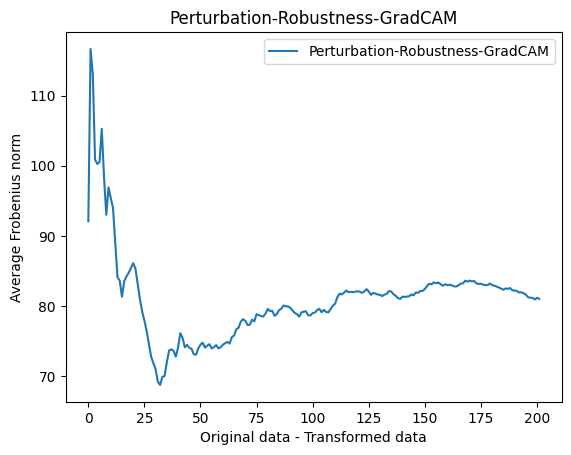

In [ ]:
# 픽셀들을 그래프로 plot하고 불확실성 영역을 표시
plt.figure()

# x축 값 생성 (예시: 0부터 499까지)
x_values = range(len(avg_Frobenius_norm))

# 플롯 생성
plt.figure()
plt.plot(x_values, avg_Frobenius_norm, label='Perturbation-Robustness-GradCAM')
#plt.fill_between(x_values, mstd_mean - mstd_std, mstd_mean + mstd_std, color='gray', alpha=0.2)

plt.title(f'Perturbation-Robustness-GradCAM')
plt.xlabel('Original data - Transformed data')
plt.ylabel('Average Frobenius norm')
plt.legend()
plt.show()

## FC dropout Grad-CAM

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
from torch import nn,Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

class FCDropoutGradCAMRev:
    def __init__(self, model, dtype=torch.float32, device=torch.device("cpu")):
        self.feature_maps = None
        self.dtype = dtype
        self.device = device

        # devide model components
        self.feature_extractor = nn.Sequential(
            model.features,
            model.avgpool)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            model.classifier
        )
        self.feature_extractor.eval()
        self.classifier.train()
        self.to(device, dtype=dtype)
        self.classifier_train = True

    def to(self, device, dtype=torch.float32):
        self.feature_extractor = self.feature_extractor.to(device, dtype=dtype)
        self.classifier = self.classifier.to(device, dtype=dtype)

    # 이미지 전처리 함수
    def preprocess_image(self, img_path):
        img = Image.open(img_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        img_preprocessed = preprocess(img)
        return img_preprocessed.unsqueeze(0)

    # 클래스 스코어 추출 함수
    def get_class_score(self, img_tensor, bs=1):
        # consider img_tensor = [1, n_c , imgd1, imgd2]
        with torch.cuda.amp.autocast():
          self.feature_extractor.zero_grad()
          self.classifier.zero_grad()

          # 이미지 전처리 및 requires_grad 설정
          img_tensor.requires_grad_(True)
          with torch.no_grad():
            Ak = self.feature_extractor(img_tensor)
          # Ak: [1, nc, fs, fs]
          Aks = Ak.clone().repeat([bs, 1, 1, 1])
          Aks.requires_grad_(True)
          out = self.classifier(Aks)
          _, predicted_class = out.max(1)
          score = out[:, predicted_class]
          score_out = score.sum()
          score_out.backward()
          grad_Aks = Aks.grad

        return predicted_class, score, Aks, grad_Aks, out

    # Grad-CAM 계산기
    def calculate_grad_cam(self, Ak, gradients):
        # 그라디언트의 글로벌 평균 계산 (by channel)
        alpha_c_k = torch.mean(gradients, dim=[2, 3])
        # [n_channel]

        # # feature maps에 그라디언트 가중치를 곱하여 클래스의 activation map 생성
        # weighted_feature_maps = Ak * alpha_c_k[:, None, None]
        # # [bs, n_channel, feat_dim, feat_dim]

        # # 클래스별 가중 feature maps의 채널별 합산
        # heatmap = torch.sum(weighted_feature_maps, dim=1).squeeze()
        heatmap = torch.einsum('ij,ijkl->ikl', alpha_c_k, Ak)

        # ReLU 적용 - 음수 값 제거
        heatmap = torch.relu(heatmap)

        # heatmap을 [0, 1] 범위로 정규화
        heatmap_min = torch.min(heatmap)
        heatmap_max = torch.max(heatmap)
        heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)

        return heatmap

    def load_img(self, img_path):
        # 이미지 전처리 및 requires_grad 설정
        img_tensor = self.preprocess_image(img_path).to(self.device, dtype=self.dtype)
        img_tensor.requires_grad_(True)
        return img_tensor

    def run_mc_grad_cam(self, img_path=None, img_tensor=None, nmc=10, bs=None):
        if img_path is not None:
            img_tensor = self.load_img(img_path, self.device)
        if bs is None:
            bs = nmc

        if not self.classifier_train:
            self.to_train_mode()

        if nmc % bs != 0:
            raise NotImplementedError
        else:
            num_batch = nmc // bs

        # assume img_tensor = [img_tensor_1, img_tensor_2, ...] = [num_img, n_channel, img_dim1, img_dim2]
        # 클래스와 해당 스코어 추출

        pred_list = []
        grad_cam_list = []
        grad_cam_mean = None
        grad_cam_std = None

        for mini_batch in range(num_batch):
            predicted_class, score, Aks, grad_Aks, out = self.get_class_score(img_tensor, bs)
            grad_cam_list.append(self.calculate_grad_cam(Aks, grad_Aks))
            pred_list.append(predicted_class)

        grad_cam_t = torch.cat(grad_cam_list)
        pred_t = torch.cat(pred_list)

        return grad_cam_t, pred_t

    def to_eval_mode(self):
        if self.classifier_train:
            self.classifier.eval()
            self.classifier_train = False

    def to_train_mode(self):
        self.classifier.train()
        self.classifier_train = True

    def run_grad_cam(self, img_path=None, img_tensor=None):

        if img_path is not None:
            img_tensor = self.load_img(img_path, self.device)

        if self.classifier_train:
            self.to_eval_mode()

        # 클래스와 해당 스코어 추출
        predicted_class, score, Ak, grad_Ak, out = self.get_class_score(img_tensor)

        grad_cam_t = self.calculate_grad_cam(Ak, grad_Ak)
        pred_t = predicted_class

        return grad_cam_t, pred_t

    def unnormalize(self, tensor):
        """
        Reverses the normalization on a tensor.
        Assumes the tensor is in the format (C, H, W) and the mean and std are for ImageNet.
        """
        if tensor.dtype != torch.float32:
          tensor = tensor.float()
        mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225], device=tensor.device)
        tensor_clone = tensor.clone()  # Create a clone to avoid modifying in-place
        for t, m, s in zip(tensor_clone, mean, std):
            t = t.mul(s).add(m)  # Unnormalize channel out-of-place
        return tensor_clone.cpu()

    def apply_heatmap(self, heatmap, original_image=None, unnormalized_image=None, alpha=0.8):
        """
        Applies the heatmap on the original image.
        """
        # Resize heatmap to the size of the original image
        if unnormalized_image is None:
          unnormalized_image = self.unnormalize(original_image).detach()
        heatmap_resized = cv2.resize(heatmap, (unnormalized_image.shape[1], unnormalized_image.shape[2]))

        # Convert heatmap to RGB
        heatmap_rgb = np.uint8(255 * heatmap_resized)
        heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)

        # Detach the tensor from the computational graph, move it to CPU, and convert to numpy
        # Then move channel to last dimension
        unnormalized_image_np = unnormalized_image.detach().cpu().permute(1, 2, 0).numpy()

        # Overlay heatmap on the original image
        superimposed_img = heatmap_rgb * alpha + unnormalized_image_np * 255 * (1 - alpha)
        superimposed_img = superimposed_img.clip(0, 255).astype(np.uint8)

        return superimposed_img

## MCD GradCAM

In [ ]:
from tqdm import tqdm
import cv2
import os

device = torch.device("cuda")
dtype = torch.bfloat16
fc_dropout_gradcam = FCDropoutGradCAMRev(model, device=device, dtype=dtype)

# 저장 경로 설정
path_to_save_mcgrad = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/mcgradcamvalue'
path_to_save_mcheatmap = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/mcheatmap'

# Ensure save directories exist
os.makedirs(path_to_save_mcgrad, exist_ok=True)
os.makedirs(path_to_save_mcheatmap, exist_ok=True)

#### mcd gradcam - original data

In [ ]:
SEED = 77
torch_fix_seed(SEED)
mcd_result_list = []
img_list = img_list1
# img_list = [img_path1 for _ in range(1000)]

T = 2500
# T = bs * num_bs
num_bs = 5
bs = int(T / num_bs)

for img_path_ in img_list:
  mcd_result_dict = {}
  img_tensor = fc_dropout_gradcam.load_img(img_path=img_path_)
  mcd_result_dict["img_path"] = img_path_
  # img_tensors.shape
  mcd_result_dict["img_tensor"] = img_tensor.cpu()
  heatmap, predicted_class = fc_dropout_gradcam.run_mc_grad_cam(img_tensor=img_tensor, nmc=T, bs=bs)
  # mc_grad_cam_heatmap = [fc_dropout_gradcam.apply_heatmap(heatmap_i, img_tensor[0]) for heatmap_i in heatmap]
  mcd_result_dict["heatmap"] = heatmap.detach().cpu().numpy()
  mcd_result_dict["predicted_class"] = predicted_class.detach().cpu().numpy()
  mcd_result_list.append(mcd_result_dict)

In [ ]:
import pickle
path_mcd_result_list = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_mcd_result_list'
#os.makedirs(os.path.dirname(path_mcd_result_list), exist_ok=True)
with open(path_mcd_result_list + '/mcd_result_list.pkl', 'wb') as f:
    pickle.dump(mcd_result_list, f)

#### mcd gradcam - transform data

In [ ]:
SEED = 77
torch_fix_seed(SEED)
mcd_result_list2 = []
img_list = img_list2
# img_list = [img_path1 for _ in range(1000)]

T = 2500
# T = bs * num_bs
num_bs = 5
bs = int(T / num_bs)

for img_path_ in img_list:
  mcd_result_dict2 = {}
  img_tensor = fc_dropout_gradcam.load_img(img_path=img_path_)
  mcd_result_dict2["img_path"] = img_path_
  # img_tensors.shape
  mcd_result_dict2["img_tensor"] = img_tensor.cpu()
  heatmap, predicted_class = fc_dropout_gradcam.run_mc_grad_cam(img_tensor=img_tensor, nmc=T, bs=bs)
  # mc_grad_cam_heatmap = [fc_dropout_gradcam.apply_heatmap(heatmap_i, img_tensor[0]) for heatmap_i in heatmap]
  mcd_result_dict2["heatmap"] = heatmap.detach().cpu().numpy()
  mcd_result_dict2["predicted_class"] = predicted_class.detach().cpu().numpy()
  mcd_result_list2.append(mcd_result_dict2)

In [ ]:
import pickle
path_mcd_result_list2 = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_mcd_result_list2'
#os.makedirs(os.path.dirname(path_mcd_result_list2), exist_ok=True)
with open(path_mcd_result_list2 + '/mcd_result_list2.pkl', 'wb') as f:
    pickle.dump(mcd_result_list2, f)

In [ ]:
np.shape(mcd_result_list[0]["heatmap"]) # "img_tensor", "img_path", "heatmap", "predicted_class"

(2500, 7, 7)

#### mcd_result_list 불러오기

In [ ]:
import pickle

path_mcd_result_list = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_mcd_result_list'

with open(path_mcd_result_list + '/mcd_result_list.pkl', 'rb') as f:
    mcd_result_list = pickle.load(f)

In [ ]:
import pickle

path_mcd_result_list2 = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_mcd_result_list2'

with open(path_mcd_result_list2 + '/mcd_result_list2.pkl', 'rb') as f:
    mcd_result_list2 = pickle.load(f)

In [ ]:
mcd_result_list[0]["heatmap"][2499]

array([[0.2374 , 0.1224 , 0.1725 , 0.1903 , 0.1572 , 0.1218 , 0.2284 ],
       [0.1787 , 0.0821 , 0.1809 , 0.2888 , 0.1589 , 0.1649 , 0.1353 ],
       [0.2642 , 0.2261 , 0.2087 , 0.374  , 0.2224 , 0.2457 , 0.     ],
       [0.401  , 0.6147 , 0.5854 , 0.3027 , 0.2878 , 0.1816 , 0.     ],
       [0.1478 , 0.435  , 0.669  , 0.4536 , 0.758  , 0.4575 , 0.07196],
       [0.1108 , 0.1539 , 0.4072 , 0.2195 , 0.7207 , 0.697  , 0.0994 ],
       [0.2351 , 0.1019 , 0.06616, 0.0776 , 0.09735, 0.1096 , 0.1643 ]],
      dtype=float16)

## 시각화 및 엔트로피 계산

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
def calc_cls_entropy(prob):
  return -(prob * np.log(prob)).sum()

preprocess1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

#### mcd gradcam - original data - 시각화

In [ ]:
mcd_save_plot_dir = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231215/plot_mcdGradCAM'
os.makedirs(mcd_save_plot_dir, exist_ok=True)

In [ ]:
for idx in range(len(mcd_result_list)):
  img_path = mcd_result_list[idx]["img_path"]
  out_class = mcd_result_list[idx]["predicted_class"]
  unnormalized_img_tensor = fc_dropout_gradcam.unnormalize(mcd_result_list[idx]["img_tensor"][0])
  mc_grad_cam_heatmap = \
   [fc_dropout_gradcam.apply_heatmap(heatmap_i.astype(np.float32), unnormalized_image=unnormalized_img_tensor) \
    for heatmap_i in mcd_result_list[idx]["heatmap"]]
  mc_grad_cam_arr = np.stack(mc_grad_cam_heatmap)

  img_original = Image.open(img_path).convert('RGB')
  img_original_processed = preprocess1(img_original).permute([1, 2, 0]).numpy()
  out_series = pd.Series(out_class).value_counts()
  out_df = pd.DataFrame(out_series, columns=["count"], index=out_series.index).reset_index()
  out_df["index"] = [class_idx_to_name[out_ind] for out_ind in out_df["index"]]
  out_df.index = out_df["index"]
  predicted_label = class_idx_to_name[pd.Series(out_class).value_counts().index[0]]

  out_df["prob"] = out_df["count"] / out_df["count"].sum()
  mcd_result_list[idx]["cls_entropy"] = calc_cls_entropy(out_df["prob"].values)

  mc_grad_cam_mean = mc_grad_cam_arr.mean(axis=0)
  #mc_grad_cam_mean = (mc_grad_cam_mean - mc_grad_cam_mean.min()) / (mc_grad_cam_mean.max() - mc_grad_cam_mean.min())
  mc_grad_cam_mean = 1- (mc_grad_cam_mean - mc_grad_cam_mean.min()) / (mc_grad_cam_mean.max() - mc_grad_cam_mean.min())

  mcd_result_list[idx]["mc_grad_cam_mean_list"] = mc_grad_cam_mean

  mc_grad_cam_mask = mc_grad_cam_arr.std(axis=0).sum(axis=2)
  mc_grad_cam_mask = (mc_grad_cam_mask - mc_grad_cam_mask.min()) / (mc_grad_cam_mask.max() - mc_grad_cam_mask.min())
  fig, axes = plt.subplots(2, 2, figsize = (8, 8))
  axes = axes.flatten()
  axes[0].imshow(img_original_processed)
  axes[0].set_title(f"Predicted as {predicted_label}")

  axes[1].imshow(img_original_processed)
  axes[1].imshow(mc_grad_cam_mean, cmap=cmap_jet, alpha=0.3)

  #axes[1].imshow(np.linalg.norm(mc_grad_cam_mean, ord=1, axis=2), cmap=cmap_jet)
  axes[1].set_title(f"MCD-GradCAM")
  axes[2].imshow(mc_grad_cam_mask, cmap="gray")
  axes[2].set_title("Uncertainty by MCD-GradCAM")
  sns.barplot(data=out_df, x='index', y='count', ax=axes[3])
  axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45, ha='right')
  axes[3].set_xlabel("")
  cls_entropy = mcd_result_list[idx]["cls_entropy"]
  axes[3].set_title(f"Predictive Entropy : {cls_entropy:.4f}")  # 소수점 두 자리까지 표시
  for i in range(3):
    axes[i].axis("off")
  fig.tight_layout()
  save_filename = os.path.join(mcd_save_plot_dir, f"plot_{idx}.png")
  plt.savefig(save_filename, bbox_inches='tight')
  plt.close(fig)

#### grad_cam_mean 및 cls_entropy저장 - mcd_result_list

#### original 데이터

In [ ]:
from tqdm import tqdm

for idx in tqdm(range(len(mcd_result_list)), desc="처리 중"):
  img_path = mcd_result_list[idx]["img_path"]
  out_class = mcd_result_list[idx]["predicted_class"]
  unnormalized_img_tensor = fc_dropout_gradcam.unnormalize(mcd_result_list[idx]["img_tensor"][0])
  mc_grad_cam_heatmap = \
   [fc_dropout_gradcam.apply_heatmap(heatmap_i.astype(np.float32), unnormalized_image=unnormalized_img_tensor) \
    for heatmap_i in mcd_result_list[idx]["heatmap"]]
  mc_grad_cam_arr = np.stack(mc_grad_cam_heatmap)

  img_original = Image.open(img_path).convert('RGB')
  img_original_processed = preprocess1(img_original).permute([1, 2, 0]).numpy()
  out_series = pd.Series(out_class).value_counts()
  out_df = pd.DataFrame(out_series, columns=["count"], index=out_series.index).reset_index()
  out_df["index"] = [class_idx_to_name[out_ind] for out_ind in out_df["index"]]
  out_df.index = out_df["index"]
  predicted_label = class_idx_to_name[pd.Series(out_class).value_counts().index[0]]

  out_df["prob"] = out_df["count"] / out_df["count"].sum()
  mcd_result_list[idx]["cls_entropy"] = calc_cls_entropy(out_df["prob"].values)

  mc_grad_cam_mean = mc_grad_cam_arr.mean(axis=0)
  mc_grad_cam_mean = (mc_grad_cam_mean - mc_grad_cam_mean.min()) / (mc_grad_cam_mean.max() - mc_grad_cam_mean.min())

  mcd_result_list[idx]["mc_grad_cam_mean_list"] = mc_grad_cam_mean
  print(str(idx + 1) + "번째 사진 처리완료")

처리 중:   0%|          | 1/202 [00:06<20:17,  6.06s/it]

1번째 사진 처리완료


처리 중:   1%|          | 2/202 [00:12<21:36,  6.48s/it]

2번째 사진 처리완료


처리 중:   1%|▏         | 3/202 [00:19<22:25,  6.76s/it]

3번째 사진 처리완료


처리 중:   2%|▏         | 4/202 [00:25<21:02,  6.38s/it]

4번째 사진 처리완료


처리 중:   2%|▏         | 5/202 [00:33<22:30,  6.86s/it]

5번째 사진 처리완료


처리 중:   3%|▎         | 6/202 [00:39<21:33,  6.60s/it]

6번째 사진 처리완료


처리 중:   3%|▎         | 7/202 [00:45<20:38,  6.35s/it]

7번째 사진 처리완료


처리 중:   4%|▍         | 8/202 [00:54<23:04,  7.14s/it]

8번째 사진 처리완료


처리 중:   4%|▍         | 9/202 [01:00<21:40,  6.74s/it]

9번째 사진 처리완료


처리 중:   5%|▍         | 10/202 [01:07<22:15,  6.96s/it]

10번째 사진 처리완료


처리 중:   5%|▌         | 11/202 [01:13<21:34,  6.78s/it]

11번째 사진 처리완료


처리 중:   6%|▌         | 12/202 [01:20<21:11,  6.69s/it]

12번째 사진 처리완료


처리 중:   6%|▋         | 13/202 [01:28<22:27,  7.13s/it]

13번째 사진 처리완료


처리 중:   7%|▋         | 14/202 [01:34<21:05,  6.73s/it]

14번째 사진 처리완료


처리 중:   7%|▋         | 15/202 [01:41<21:08,  6.78s/it]

15번째 사진 처리완료


처리 중:   8%|▊         | 16/202 [01:48<21:03,  6.79s/it]

16번째 사진 처리완료


처리 중:   8%|▊         | 17/202 [01:53<20:10,  6.54s/it]

17번째 사진 처리완료


처리 중:   9%|▉         | 18/202 [02:01<21:05,  6.88s/it]

18번째 사진 처리완료


처리 중:   9%|▉         | 19/202 [02:07<20:07,  6.60s/it]

19번째 사진 처리완료


처리 중:  10%|▉         | 20/202 [02:13<19:20,  6.38s/it]

20번째 사진 처리완료


처리 중:  10%|█         | 21/202 [02:21<21:00,  6.96s/it]

21번째 사진 처리완료


처리 중:  11%|█         | 22/202 [02:27<19:55,  6.64s/it]

22번째 사진 처리완료


처리 중:  11%|█▏        | 23/202 [02:34<19:56,  6.69s/it]

23번째 사진 처리완료


처리 중:  12%|█▏        | 24/202 [02:43<21:43,  7.32s/it]

24번째 사진 처리완료


처리 중:  12%|█▏        | 25/202 [02:49<20:32,  6.96s/it]

25번째 사진 처리완료


처리 중:  13%|█▎        | 26/202 [02:57<21:38,  7.38s/it]

26번째 사진 처리완료


처리 중:  13%|█▎        | 27/202 [03:03<20:10,  6.92s/it]

27번째 사진 처리완료


처리 중:  14%|█▍        | 28/202 [03:10<19:38,  6.77s/it]

28번째 사진 처리완료


처리 중:  14%|█▍        | 29/202 [03:17<20:10,  7.00s/it]

29번째 사진 처리완료


처리 중:  15%|█▍        | 30/202 [03:23<19:05,  6.66s/it]

30번째 사진 처리완료


처리 중:  15%|█▌        | 31/202 [03:31<19:49,  6.95s/it]

31번째 사진 처리완료


처리 중:  16%|█▌        | 32/202 [03:37<19:05,  6.74s/it]

32번째 사진 처리완료


처리 중:  16%|█▋        | 33/202 [03:43<18:19,  6.50s/it]

33번째 사진 처리완료


처리 중:  17%|█▋        | 34/202 [03:51<19:39,  7.02s/it]

34번째 사진 처리완료


처리 중:  17%|█▋        | 35/202 [04:00<20:52,  7.50s/it]

35번째 사진 처리완료


처리 중:  18%|█▊        | 36/202 [04:11<23:45,  8.59s/it]

36번째 사진 처리완료


처리 중:  18%|█▊        | 37/202 [04:17<21:36,  7.86s/it]

37번째 사진 처리완료


처리 중:  19%|█▉        | 38/202 [04:25<21:43,  7.95s/it]

38번째 사진 처리완료


처리 중:  19%|█▉        | 39/202 [04:31<19:41,  7.25s/it]

39번째 사진 처리완료


처리 중:  20%|█▉        | 40/202 [04:41<21:52,  8.10s/it]

40번째 사진 처리완료


처리 중:  20%|██        | 41/202 [04:50<22:52,  8.52s/it]

41번째 사진 처리완료


처리 중:  21%|██        | 42/202 [05:00<23:59,  9.00s/it]

42번째 사진 처리완료


처리 중:  21%|██▏       | 43/202 [05:08<22:34,  8.52s/it]

43번째 사진 처리완료


처리 중:  22%|██▏       | 44/202 [05:17<22:37,  8.59s/it]

44번째 사진 처리완료


처리 중:  22%|██▏       | 45/202 [05:23<20:31,  7.84s/it]

45번째 사진 처리완료


처리 중:  23%|██▎       | 46/202 [05:29<18:54,  7.27s/it]

46번째 사진 처리완료


처리 중:  23%|██▎       | 47/202 [05:38<20:40,  8.01s/it]

47번째 사진 처리완료


처리 중:  24%|██▍       | 48/202 [05:44<18:51,  7.35s/it]

48번째 사진 처리완료


처리 중:  24%|██▍       | 49/202 [05:52<19:30,  7.65s/it]

49번째 사진 처리완료


처리 중:  25%|██▍       | 50/202 [05:58<18:01,  7.11s/it]

50번째 사진 처리완료


처리 중:  25%|██▌       | 51/202 [06:04<16:53,  6.71s/it]

51번째 사진 처리완료


처리 중:  26%|██▌       | 52/202 [06:12<17:46,  7.11s/it]

52번째 사진 처리완료


처리 중:  26%|██▌       | 53/202 [06:18<16:42,  6.73s/it]

53번째 사진 처리완료


처리 중:  27%|██▋       | 54/202 [06:25<16:51,  6.84s/it]

54번째 사진 처리완료


처리 중:  27%|██▋       | 55/202 [06:32<16:37,  6.78s/it]

55번째 사진 처리완료


처리 중:  28%|██▊       | 56/202 [06:37<15:40,  6.44s/it]

56번째 사진 처리완료


처리 중:  28%|██▊       | 57/202 [06:45<16:45,  6.93s/it]

57번째 사진 처리완료


처리 중:  29%|██▊       | 58/202 [06:54<18:10,  7.57s/it]

58번째 사진 처리완료


처리 중:  29%|██▉       | 59/202 [07:02<18:21,  7.70s/it]

59번째 사진 처리완료


처리 중:  30%|██▉       | 60/202 [07:08<16:43,  7.07s/it]

60번째 사진 처리완료


처리 중:  30%|███       | 61/202 [07:14<15:47,  6.72s/it]

61번째 사진 처리완료


처리 중:  31%|███       | 62/202 [07:23<16:59,  7.28s/it]

62번째 사진 처리완료


처리 중:  31%|███       | 63/202 [07:29<15:59,  6.90s/it]

63번째 사진 처리완료


처리 중:  32%|███▏      | 64/202 [07:36<16:30,  7.18s/it]

64번째 사진 처리완료


처리 중:  32%|███▏      | 65/202 [07:42<15:36,  6.84s/it]

65번째 사진 처리완료


처리 중:  33%|███▎      | 66/202 [07:48<14:53,  6.57s/it]

66번째 사진 처리완료


처리 중:  33%|███▎      | 67/202 [07:56<15:41,  6.97s/it]

67번째 사진 처리완료


처리 중:  34%|███▎      | 68/202 [08:02<14:46,  6.62s/it]

68번째 사진 처리완료


처리 중:  34%|███▍      | 69/202 [08:11<15:53,  7.17s/it]

69번째 사진 처리완료


처리 중:  35%|███▍      | 70/202 [08:17<15:05,  6.86s/it]

70번째 사진 처리완료


처리 중:  35%|███▌      | 71/202 [08:22<14:16,  6.54s/it]

71번째 사진 처리완료


처리 중:  36%|███▌      | 72/202 [08:31<15:18,  7.07s/it]

72번째 사진 처리완료


처리 중:  36%|███▌      | 73/202 [08:37<14:26,  6.71s/it]

73번째 사진 처리완료


처리 중:  37%|███▋      | 74/202 [08:43<14:14,  6.68s/it]

74번째 사진 처리완료


처리 중:  37%|███▋      | 75/202 [08:50<14:27,  6.83s/it]

75번째 사진 처리완료


처리 중:  38%|███▊      | 76/202 [08:56<13:35,  6.47s/it]

76번째 사진 처리완료


처리 중:  38%|███▊      | 77/202 [09:04<14:16,  6.85s/it]

77번째 사진 처리완료


처리 중:  39%|███▊      | 78/202 [09:10<13:44,  6.65s/it]

78번째 사진 처리완료


처리 중:  39%|███▉      | 79/202 [09:16<13:14,  6.46s/it]

79번째 사진 처리완료


처리 중:  40%|███▉      | 80/202 [09:24<14:06,  6.94s/it]

80번째 사진 처리완료


처리 중:  40%|████      | 81/202 [09:30<13:20,  6.62s/it]

81번째 사진 처리완료


처리 중:  41%|████      | 82/202 [09:37<13:21,  6.68s/it]

82번째 사진 처리완료


처리 중:  41%|████      | 83/202 [09:45<14:00,  7.06s/it]

83번째 사진 처리완료


처리 중:  42%|████▏     | 84/202 [09:51<13:17,  6.76s/it]

84번째 사진 처리완료


처리 중:  42%|████▏     | 85/202 [09:59<14:04,  7.22s/it]

85번째 사진 처리완료


처리 중:  43%|████▎     | 86/202 [10:05<13:09,  6.80s/it]

86번째 사진 처리완료


처리 중:  43%|████▎     | 87/202 [10:12<13:02,  6.81s/it]

87번째 사진 처리완료


처리 중:  44%|████▎     | 88/202 [10:19<13:00,  6.84s/it]

88번째 사진 처리완료


처리 중:  44%|████▍     | 89/202 [10:25<12:43,  6.76s/it]

89번째 사진 처리완료


처리 중:  45%|████▍     | 90/202 [10:33<13:23,  7.18s/it]

90번째 사진 처리완료


처리 중:  45%|████▌     | 91/202 [10:39<12:32,  6.78s/it]

91번째 사진 처리완료


처리 중:  46%|████▌     | 92/202 [10:46<12:12,  6.66s/it]

92번째 사진 처리완료


처리 중:  46%|████▌     | 93/202 [10:53<12:30,  6.89s/it]

93번째 사진 처리완료


처리 중:  47%|████▋     | 94/202 [10:59<11:51,  6.59s/it]

94번째 사진 처리완료


처리 중:  47%|████▋     | 95/202 [11:09<13:28,  7.55s/it]

95번째 사진 처리완료


처리 중:  48%|████▊     | 96/202 [11:15<12:39,  7.17s/it]

96번째 사진 처리완료


처리 중:  48%|████▊     | 97/202 [11:21<11:47,  6.74s/it]

97번째 사진 처리완료


처리 중:  49%|████▊     | 98/202 [11:29<12:30,  7.21s/it]

98번째 사진 처리완료


처리 중:  49%|████▉     | 99/202 [11:35<11:37,  6.77s/it]

99번째 사진 처리완료


처리 중:  50%|████▉     | 100/202 [11:41<11:27,  6.74s/it]

100번째 사진 처리완료


처리 중:  50%|█████     | 101/202 [11:49<11:30,  6.84s/it]

101번째 사진 처리완료


처리 중:  50%|█████     | 102/202 [11:54<10:57,  6.57s/it]

102번째 사진 처리완료


처리 중:  51%|█████     | 103/202 [12:03<11:34,  7.02s/it]

103번째 사진 처리완료


처리 중:  51%|█████▏    | 104/202 [12:08<10:49,  6.63s/it]

104번째 사진 처리완료


처리 중:  52%|█████▏    | 105/202 [12:14<10:30,  6.50s/it]

105번째 사진 처리완료


처리 중:  52%|█████▏    | 106/202 [12:22<10:52,  6.80s/it]

106번째 사진 처리완료


처리 중:  53%|█████▎    | 107/202 [12:28<10:17,  6.51s/it]

107번째 사진 처리완료


처리 중:  53%|█████▎    | 108/202 [12:35<10:41,  6.82s/it]

108번째 사진 처리완료


처리 중:  54%|█████▍    | 109/202 [12:41<10:13,  6.60s/it]

109번째 사진 처리완료


처리 중:  54%|█████▍    | 110/202 [12:47<09:42,  6.33s/it]

110번째 사진 처리완료


처리 중:  55%|█████▍    | 111/202 [12:55<10:27,  6.89s/it]

111번째 사진 처리완료


처리 중:  55%|█████▌    | 112/202 [13:01<09:49,  6.55s/it]

112번째 사진 처리완료


처리 중:  56%|█████▌    | 113/202 [13:08<09:40,  6.52s/it]

113번째 사진 처리완료


처리 중:  56%|█████▋    | 114/202 [13:15<09:54,  6.75s/it]

114번째 사진 처리완료


처리 중:  57%|█████▋    | 115/202 [13:21<09:21,  6.45s/it]

115번째 사진 처리완료


처리 중:  57%|█████▋    | 116/202 [13:28<09:49,  6.85s/it]

116번째 사진 처리완료


처리 중:  58%|█████▊    | 117/202 [13:34<09:20,  6.59s/it]

117번째 사진 처리완료


처리 중:  58%|█████▊    | 118/202 [13:49<12:26,  8.89s/it]

118번째 사진 처리완료


처리 중:  59%|█████▉    | 119/202 [13:59<13:02,  9.43s/it]

119번째 사진 처리완료


처리 중:  59%|█████▉    | 120/202 [14:08<12:46,  9.35s/it]

120번째 사진 처리완료


처리 중:  60%|█████▉    | 121/202 [14:17<12:10,  9.02s/it]

121번째 사진 처리완료


처리 중:  60%|██████    | 122/202 [14:25<11:42,  8.78s/it]

122번째 사진 처리완료


처리 중:  61%|██████    | 123/202 [14:32<10:48,  8.21s/it]

123번째 사진 처리완료


처리 중:  61%|██████▏   | 124/202 [14:42<11:23,  8.76s/it]

124번째 사진 처리완료


처리 중:  62%|██████▏   | 125/202 [14:48<10:05,  7.87s/it]

125번째 사진 처리완료


처리 중:  62%|██████▏   | 126/202 [14:54<09:31,  7.52s/it]

126번째 사진 처리완료


처리 중:  63%|██████▎   | 127/202 [15:01<09:10,  7.34s/it]

127번째 사진 처리완료


처리 중:  63%|██████▎   | 128/202 [15:07<08:28,  6.87s/it]

128번째 사진 처리완료


처리 중:  64%|██████▍   | 129/202 [15:15<08:44,  7.19s/it]

129번째 사진 처리완료


처리 중:  64%|██████▍   | 130/202 [15:24<09:08,  7.62s/it]

130번째 사진 처리완료


처리 중:  65%|██████▍   | 131/202 [15:30<08:25,  7.12s/it]

131번째 사진 처리완료


처리 중:  65%|██████▌   | 132/202 [15:38<08:48,  7.55s/it]

132번째 사진 처리완료


처리 중:  66%|██████▌   | 133/202 [15:44<08:06,  7.05s/it]

133번째 사진 처리완료


처리 중:  66%|██████▋   | 134/202 [15:51<07:58,  7.04s/it]

134번째 사진 처리완료


처리 중:  67%|██████▋   | 135/202 [15:58<07:49,  7.01s/it]

135번째 사진 처리완료


처리 중:  67%|██████▋   | 136/202 [16:05<07:39,  6.96s/it]

136번째 사진 처리완료


처리 중:  68%|██████▊   | 137/202 [16:14<08:08,  7.52s/it]

137번째 사진 처리완료


처리 중:  68%|██████▊   | 138/202 [16:19<07:28,  7.01s/it]

138번째 사진 처리완료


처리 중:  69%|██████▉   | 139/202 [16:26<07:22,  7.02s/it]

139번째 사진 처리완료


처리 중:  69%|██████▉   | 140/202 [16:33<07:10,  6.94s/it]

140번째 사진 처리완료


처리 중:  70%|██████▉   | 141/202 [16:39<06:44,  6.63s/it]

141번째 사진 처리완료


처리 중:  70%|███████   | 142/202 [16:47<07:02,  7.04s/it]

142번째 사진 처리완료


처리 중:  71%|███████   | 143/202 [16:53<06:35,  6.71s/it]

143번째 사진 처리완료


처리 중:  71%|███████▏  | 144/202 [16:59<06:14,  6.46s/it]

144번째 사진 처리완료


처리 중:  72%|███████▏  | 145/202 [17:07<06:33,  6.91s/it]

145번째 사진 처리완료


처리 중:  72%|███████▏  | 146/202 [17:13<06:05,  6.52s/it]

146번째 사진 처리완료


처리 중:  73%|███████▎  | 147/202 [17:20<06:12,  6.78s/it]

147번째 사진 처리완료


처리 중:  73%|███████▎  | 148/202 [17:26<06:00,  6.68s/it]

148번째 사진 처리완료


처리 중:  74%|███████▍  | 149/202 [17:32<05:37,  6.36s/it]

149번째 사진 처리완료


처리 중:  74%|███████▍  | 150/202 [17:40<06:02,  6.97s/it]

150번째 사진 처리완료


처리 중:  75%|███████▍  | 151/202 [17:47<05:45,  6.76s/it]

151번째 사진 처리완료


처리 중:  75%|███████▌  | 152/202 [17:53<05:38,  6.78s/it]

152번째 사진 처리완료


처리 중:  76%|███████▌  | 153/202 [18:00<05:33,  6.81s/it]

153번째 사진 처리완료


처리 중:  76%|███████▌  | 154/202 [18:06<05:11,  6.49s/it]

154번째 사진 처리완료


처리 중:  77%|███████▋  | 155/202 [18:15<05:44,  7.34s/it]

155번째 사진 처리완료


처리 중:  77%|███████▋  | 156/202 [18:21<05:15,  6.86s/it]

156번째 사진 처리완료


처리 중:  78%|███████▊  | 157/202 [18:28<05:04,  6.77s/it]

157번째 사진 처리완료


처리 중:  78%|███████▊  | 158/202 [18:35<05:01,  6.85s/it]

158번째 사진 처리완료


처리 중:  79%|███████▊  | 159/202 [18:40<04:39,  6.51s/it]

159번째 사진 처리완료


처리 중:  79%|███████▉  | 160/202 [18:48<04:47,  6.84s/it]

160번째 사진 처리완료


처리 중:  80%|███████▉  | 161/202 [18:54<04:33,  6.68s/it]

161번째 사진 처리완료


처리 중:  80%|████████  | 162/202 [19:00<04:17,  6.43s/it]

162번째 사진 처리완료


처리 중:  81%|████████  | 163/202 [19:08<04:30,  6.93s/it]

163번째 사진 처리완료


처리 중:  81%|████████  | 164/202 [19:14<04:11,  6.62s/it]

164번째 사진 처리완료


처리 중:  82%|████████▏ | 165/202 [19:21<04:11,  6.79s/it]

165번째 사진 처리완료


처리 중:  82%|████████▏ | 166/202 [19:28<04:03,  6.77s/it]

166번째 사진 처리완료


처리 중:  83%|████████▎ | 167/202 [19:36<04:12,  7.22s/it]

167번째 사진 처리완료


처리 중:  83%|████████▎ | 168/202 [19:44<04:07,  7.29s/it]

168번째 사진 처리완료


처리 중:  84%|████████▎ | 169/202 [19:50<03:46,  6.87s/it]

169번째 사진 처리완료


처리 중:  84%|████████▍ | 170/202 [19:57<03:46,  7.09s/it]

170번째 사진 처리완료


처리 중:  85%|████████▍ | 171/202 [20:03<03:30,  6.78s/it]

171번째 사진 처리완료


처리 중:  85%|████████▌ | 172/202 [20:09<03:13,  6.45s/it]

172번째 사진 처리완료


처리 중:  86%|████████▌ | 173/202 [20:18<03:24,  7.06s/it]

173번째 사진 처리완료


처리 중:  86%|████████▌ | 174/202 [20:23<03:06,  6.64s/it]

174번째 사진 처리완료


처리 중:  87%|████████▋ | 175/202 [20:30<02:58,  6.61s/it]

175번째 사진 처리완료


처리 중:  87%|████████▋ | 176/202 [20:37<02:57,  6.81s/it]

176번째 사진 처리완료


처리 중:  88%|████████▊ | 177/202 [20:43<02:43,  6.53s/it]

177번째 사진 처리완료


처리 중:  88%|████████▊ | 178/202 [20:51<02:46,  6.95s/it]

178번째 사진 처리완료


처리 중:  89%|████████▊ | 179/202 [20:57<02:33,  6.66s/it]

179번째 사진 처리완료


처리 중:  89%|████████▉ | 180/202 [21:03<02:20,  6.40s/it]

180번째 사진 처리완료


처리 중:  90%|████████▉ | 181/202 [21:11<02:24,  6.88s/it]

181번째 사진 처리완료


처리 중:  90%|█████████ | 182/202 [21:16<02:10,  6.53s/it]

182번째 사진 처리완료


처리 중:  91%|█████████ | 183/202 [21:23<02:07,  6.69s/it]

183번째 사진 처리완료


처리 중:  91%|█████████ | 184/202 [21:30<02:00,  6.72s/it]

184번째 사진 처리완료


처리 중:  92%|█████████▏| 185/202 [21:36<01:49,  6.46s/it]

185번째 사진 처리완료


처리 중:  92%|█████████▏| 186/202 [21:44<01:52,  7.04s/it]

186번째 사진 처리완료


처리 중:  93%|█████████▎| 187/202 [21:50<01:39,  6.62s/it]

187번째 사진 처리완료


처리 중:  93%|█████████▎| 188/202 [21:56<01:31,  6.53s/it]

188번째 사진 처리완료


처리 중:  94%|█████████▎| 189/202 [22:04<01:27,  6.76s/it]

189번째 사진 처리완료


처리 중:  94%|█████████▍| 190/202 [22:09<01:17,  6.42s/it]

190번째 사진 처리완료


처리 중:  95%|█████████▍| 191/202 [22:17<01:14,  6.76s/it]

191번째 사진 처리완료


처리 중:  95%|█████████▌| 192/202 [22:23<01:05,  6.54s/it]

192번째 사진 처리완료


처리 중:  96%|█████████▌| 193/202 [22:29<00:57,  6.37s/it]

193번째 사진 처리완료


처리 중:  96%|█████████▌| 194/202 [22:37<00:55,  6.89s/it]

194번째 사진 처리완료


처리 중:  97%|█████████▋| 195/202 [22:43<00:46,  6.60s/it]

195번째 사진 처리완료


처리 중:  97%|█████████▋| 196/202 [22:49<00:39,  6.57s/it]

196번째 사진 처리완료


처리 중:  98%|█████████▊| 197/202 [22:57<00:33,  6.78s/it]

197번째 사진 처리완료


처리 중:  98%|█████████▊| 198/202 [23:02<00:25,  6.49s/it]

198번째 사진 처리완료


처리 중:  99%|█████████▊| 199/202 [23:10<00:20,  6.94s/it]

199번째 사진 처리완료


처리 중:  99%|█████████▉| 200/202 [23:16<00:13,  6.65s/it]

200번째 사진 처리완료


처리 중: 100%|█████████▉| 201/202 [23:22<00:06,  6.39s/it]

201번째 사진 처리완료


처리 중: 100%|██████████| 202/202 [23:30<00:00,  6.98s/it]

202번째 사진 처리완료


In [ ]:
np.shape(mcd_result_list[4]["mc_grad_cam_mean_list"])
# mcd_result_list[4]["cls_entropy"]
# "img_tensor", "img_path", "heatmap", "predicted_class" "cls entropy" "mc_grad_cam_mean_list"

(224, 224, 3)

#### transform data

In [ ]:
from tqdm import tqdm

for idx in tqdm(range(len(mcd_result_list2)), desc="처리 중"):
  img_path = mcd_result_list2[idx]["img_path"]
  out_class = mcd_result_list2[idx]["predicted_class"]
  unnormalized_img_tensor = fc_dropout_gradcam.unnormalize(mcd_result_list2[idx]["img_tensor"][0])
  mc_grad_cam_heatmap = \
   [fc_dropout_gradcam.apply_heatmap(heatmap_i.astype(np.float32), unnormalized_image=unnormalized_img_tensor) \
    for heatmap_i in mcd_result_list2[idx]["heatmap"]]
  mc_grad_cam_arr = np.stack(mc_grad_cam_heatmap)

  img_transform = Image.open(img_path).convert('RGB')
  img_transform_processed = preprocess1(img_transform).permute([1, 2, 0]).numpy()
  out_series = pd.Series(out_class).value_counts()
  out_df = pd.DataFrame(out_series, columns=["count"], index=out_series.index).reset_index()
  out_df["index"] = [class_idx_to_name[out_ind] for out_ind in out_df["index"]]
  out_df.index = out_df["index"]
  predicted_label = class_idx_to_name[pd.Series(out_class).value_counts().index[0]]

  out_df["prob"] = out_df["count"] / out_df["count"].sum()
  mcd_result_list2[idx]["cls_entropy"] = calc_cls_entropy(out_df["prob"].values)

  mc_grad_cam_mean = mc_grad_cam_arr.mean(axis=0)
  mc_grad_cam_mean = (mc_grad_cam_mean - mc_grad_cam_mean.min()) / (mc_grad_cam_mean.max() - mc_grad_cam_mean.min())

  mcd_result_list2[idx]["mc_grad_cam_mean_list"] = mc_grad_cam_mean
  print(str(idx + 1) + "번째 사진 처리완료")

처리 중:   0%|          | 1/202 [00:08<28:30,  8.51s/it]

1번째 사진 처리완료


처리 중:   1%|          | 2/202 [00:14<23:18,  6.99s/it]

2번째 사진 처리완료


처리 중:   1%|▏         | 3/202 [00:22<24:48,  7.48s/it]

3번째 사진 처리완료


처리 중:   2%|▏         | 4/202 [00:28<22:30,  6.82s/it]

4번째 사진 처리완료


처리 중:   2%|▏         | 5/202 [00:34<21:39,  6.60s/it]

5번째 사진 처리완료


처리 중:   3%|▎         | 6/202 [00:42<22:45,  6.97s/it]

6번째 사진 처리완료


처리 중:   3%|▎         | 7/202 [00:48<21:25,  6.59s/it]

7번째 사진 처리완료


처리 중:   4%|▍         | 8/202 [00:55<22:13,  6.88s/it]

8번째 사진 처리완료


처리 중:   4%|▍         | 9/202 [01:01<21:43,  6.75s/it]

9번째 사진 처리완료


처리 중:   5%|▍         | 10/202 [01:07<20:44,  6.48s/it]

10번째 사진 처리완료


처리 중:   5%|▌         | 11/202 [01:16<22:19,  7.01s/it]

11번째 사진 처리완료


처리 중:   6%|▌         | 12/202 [01:23<22:24,  7.08s/it]

12번째 사진 처리완료


처리 중:   6%|▋         | 13/202 [01:31<23:06,  7.34s/it]

13번째 사진 처리완료


처리 중:   7%|▋         | 14/202 [01:37<21:46,  6.95s/it]

14번째 사진 처리완료


처리 중:   7%|▋         | 15/202 [01:43<20:44,  6.65s/it]

15번째 사진 처리완료


처리 중:   8%|▊         | 16/202 [01:51<21:52,  7.06s/it]

16번째 사진 처리완료


처리 중:   8%|▊         | 17/202 [01:57<20:33,  6.67s/it]

17번째 사진 처리완료


처리 중:   9%|▉         | 18/202 [02:04<21:22,  6.97s/it]

18번째 사진 처리완료


처리 중:   9%|▉         | 19/202 [02:11<20:41,  6.78s/it]

19번째 사진 처리완료


처리 중:  10%|▉         | 20/202 [02:16<19:47,  6.52s/it]

20번째 사진 처리완료


처리 중:  10%|█         | 21/202 [02:25<21:51,  7.25s/it]

21번째 사진 처리완료


처리 중:  11%|█         | 22/202 [02:33<21:55,  7.31s/it]

22번째 사진 처리완료


처리 중:  11%|█▏        | 23/202 [02:40<21:53,  7.34s/it]

23번째 사진 처리완료


처리 중:  12%|█▏        | 24/202 [02:48<21:48,  7.35s/it]

24번째 사진 처리완료


처리 중:  12%|█▏        | 25/202 [02:54<20:30,  6.95s/it]

25번째 사진 처리완료


처리 중:  13%|█▎        | 26/202 [03:02<21:31,  7.34s/it]

26번째 사진 처리완료


처리 중:  13%|█▎        | 27/202 [03:08<20:05,  6.89s/it]

27번째 사진 처리완료


처리 중:  14%|█▍        | 28/202 [03:15<20:10,  6.96s/it]

28번째 사진 처리완료


처리 중:  14%|█▍        | 29/202 [03:21<19:47,  6.86s/it]

29번째 사진 처리완료


처리 중:  15%|█▍        | 30/202 [03:27<18:46,  6.55s/it]

30번째 사진 처리완료


처리 중:  15%|█▌        | 31/202 [03:36<20:23,  7.16s/it]

31번째 사진 처리완료


처리 중:  16%|█▌        | 32/202 [03:42<19:10,  6.77s/it]

32번째 사진 처리완료


처리 중:  16%|█▋        | 33/202 [03:48<19:00,  6.75s/it]

33번째 사진 처리완료


처리 중:  17%|█▋        | 34/202 [03:56<19:10,  6.85s/it]

34번째 사진 처리완료


처리 중:  17%|█▋        | 35/202 [04:01<18:14,  6.56s/it]

35번째 사진 처리완료


처리 중:  18%|█▊        | 36/202 [04:10<19:29,  7.04s/it]

36번째 사진 처리완료


처리 중:  18%|█▊        | 37/202 [04:16<18:36,  6.77s/it]

37번째 사진 처리완료


처리 중:  19%|█▉        | 38/202 [04:22<18:09,  6.64s/it]

38번째 사진 처리완료


처리 중:  19%|█▉        | 39/202 [04:30<18:51,  6.94s/it]

39번째 사진 처리완료


처리 중:  20%|█▉        | 40/202 [04:36<17:55,  6.64s/it]

40번째 사진 처리완료


처리 중:  20%|██        | 41/202 [04:44<18:49,  7.02s/it]

41번째 사진 처리완료


처리 중:  21%|██        | 42/202 [04:49<17:47,  6.67s/it]

42번째 사진 처리완료


처리 중:  21%|██▏       | 43/202 [04:55<17:01,  6.42s/it]

43번째 사진 처리완료


처리 중:  22%|██▏       | 44/202 [05:03<18:03,  6.86s/it]

44번째 사진 처리완료


처리 중:  22%|██▏       | 45/202 [05:09<17:08,  6.55s/it]

45번째 사진 처리완료


처리 중:  23%|██▎       | 46/202 [05:17<17:51,  6.87s/it]

46번째 사진 처리완료


처리 중:  23%|██▎       | 47/202 [05:23<17:12,  6.66s/it]

47번째 사진 처리완료


처리 중:  24%|██▍       | 48/202 [05:29<16:37,  6.47s/it]

48번째 사진 처리완료


처리 중:  24%|██▍       | 49/202 [05:37<17:53,  7.02s/it]

49번째 사진 처리완료


처리 중:  25%|██▍       | 50/202 [05:43<17:00,  6.71s/it]

50번째 사진 처리완료


처리 중:  25%|██▌       | 51/202 [05:50<17:15,  6.86s/it]

51번째 사진 처리완료


처리 중:  26%|██▌       | 52/202 [05:57<17:04,  6.83s/it]

52번째 사진 처리완료


처리 중:  26%|██▌       | 53/202 [06:03<16:19,  6.57s/it]

53번째 사진 처리완료


처리 중:  27%|██▋       | 54/202 [06:11<17:30,  7.10s/it]

54번째 사진 처리완료


처리 중:  27%|██▋       | 55/202 [06:17<16:31,  6.74s/it]

55번째 사진 처리완료


처리 중:  28%|██▊       | 56/202 [06:24<16:27,  6.77s/it]

56번째 사진 처리완료


처리 중:  28%|██▊       | 57/202 [06:31<16:39,  6.89s/it]

57번째 사진 처리완료


처리 중:  29%|██▊       | 58/202 [06:37<15:49,  6.59s/it]

58번째 사진 처리완료


처리 중:  29%|██▉       | 59/202 [06:46<17:38,  7.40s/it]

59번째 사진 처리완료


처리 중:  30%|██▉       | 60/202 [06:54<17:50,  7.54s/it]

60번째 사진 처리완료


처리 중:  30%|███       | 61/202 [07:00<16:32,  7.04s/it]

61번째 사진 처리완료


처리 중:  31%|███       | 62/202 [07:09<17:28,  7.49s/it]

62번째 사진 처리완료


처리 중:  31%|███       | 63/202 [07:15<16:38,  7.19s/it]

63번째 사진 처리완료


처리 중:  32%|███▏      | 64/202 [07:22<16:10,  7.03s/it]

64번째 사진 처리완료


처리 중:  32%|███▏      | 65/202 [07:29<16:09,  7.08s/it]

65번째 사진 처리완료


처리 중:  33%|███▎      | 66/202 [07:35<15:18,  6.75s/it]

66번째 사진 처리완료


처리 중:  33%|███▎      | 67/202 [07:43<16:05,  7.15s/it]

67번째 사진 처리완료


처리 중:  34%|███▎      | 68/202 [07:49<15:13,  6.82s/it]

68번째 사진 처리완료


처리 중:  34%|███▍      | 69/202 [07:56<14:51,  6.70s/it]

69번째 사진 처리완료


처리 중:  35%|███▍      | 70/202 [08:03<15:18,  6.96s/it]

70번째 사진 처리완료


처리 중:  35%|███▌      | 71/202 [08:09<14:29,  6.64s/it]

71번째 사진 처리완료


처리 중:  36%|███▌      | 72/202 [08:17<15:24,  7.11s/it]

72번째 사진 처리완료


처리 중:  36%|███▌      | 73/202 [08:23<14:31,  6.75s/it]

73번째 사진 처리완료


처리 중:  37%|███▋      | 74/202 [08:30<14:09,  6.64s/it]

74번째 사진 처리완료


처리 중:  37%|███▋      | 75/202 [08:37<14:42,  6.95s/it]

75번째 사진 처리완료


처리 중:  38%|███▊      | 76/202 [08:43<13:54,  6.62s/it]

76번째 사진 처리완료


처리 중:  38%|███▊      | 77/202 [08:51<14:30,  6.97s/it]

77번째 사진 처리완료


처리 중:  39%|███▊      | 78/202 [08:57<13:55,  6.74s/it]

78번째 사진 처리완료


처리 중:  39%|███▉      | 79/202 [09:03<13:27,  6.56s/it]

79번째 사진 처리완료


처리 중:  40%|███▉      | 80/202 [09:11<14:06,  6.94s/it]

80번째 사진 처리완료


처리 중:  40%|████      | 81/202 [09:17<13:23,  6.64s/it]

81번째 사진 처리완료


처리 중:  41%|████      | 82/202 [09:25<13:58,  6.99s/it]

82번째 사진 처리완료


처리 중:  41%|████      | 83/202 [09:31<13:37,  6.87s/it]

83번째 사진 처리완료


처리 중:  42%|████▏     | 84/202 [09:37<13:00,  6.62s/it]

84번째 사진 처리완료


처리 중:  42%|████▏     | 85/202 [09:45<13:34,  6.96s/it]

85번째 사진 처리완료


처리 중:  43%|████▎     | 86/202 [09:51<12:49,  6.64s/it]

86번째 사진 처리완료


처리 중:  43%|████▎     | 87/202 [09:58<12:59,  6.78s/it]

87번째 사진 처리완료


처리 중:  44%|████▎     | 88/202 [10:05<12:52,  6.78s/it]

88번째 사진 처리완료


처리 중:  44%|████▍     | 89/202 [10:11<12:19,  6.54s/it]

89번째 사진 처리완료


처리 중:  45%|████▍     | 90/202 [10:19<13:09,  7.05s/it]

90번째 사진 처리완료


처리 중:  45%|████▌     | 91/202 [10:25<12:22,  6.69s/it]

91번째 사진 처리완료


처리 중:  46%|████▌     | 92/202 [10:32<12:14,  6.68s/it]

92번째 사진 처리완료


처리 중:  46%|████▌     | 93/202 [10:39<12:29,  6.88s/it]

93번째 사진 처리완료


처리 중:  47%|████▋     | 94/202 [10:45<11:57,  6.64s/it]

94번째 사진 처리완료


처리 중:  47%|████▋     | 95/202 [10:53<12:33,  7.04s/it]

95번째 사진 처리완료


처리 중:  48%|████▊     | 96/202 [11:01<12:58,  7.34s/it]

96번째 사진 처리완료


처리 중:  48%|████▊     | 97/202 [11:08<12:45,  7.29s/it]

97번째 사진 처리완료


처리 중:  49%|████▊     | 98/202 [11:15<12:17,  7.10s/it]

98번째 사진 처리완료


처리 중:  49%|████▉     | 99/202 [11:21<11:37,  6.78s/it]

99번째 사진 처리완료


처리 중:  50%|████▉     | 100/202 [11:29<12:20,  7.26s/it]

100번째 사진 처리완료


처리 중:  50%|█████     | 101/202 [11:35<11:30,  6.84s/it]

101번째 사진 처리완료


처리 중:  50%|█████     | 102/202 [11:42<11:17,  6.78s/it]

102번째 사진 처리완료


처리 중:  51%|█████     | 103/202 [11:49<11:25,  6.92s/it]

103번째 사진 처리완료


처리 중:  51%|█████▏    | 104/202 [11:55<10:46,  6.60s/it]

104번째 사진 처리완료


처리 중:  52%|█████▏    | 105/202 [12:03<11:25,  7.07s/it]

105번째 사진 처리완료


처리 중:  52%|█████▏    | 106/202 [12:09<10:45,  6.72s/it]

106번째 사진 처리완료


처리 중:  53%|█████▎    | 107/202 [12:15<10:26,  6.59s/it]

107번째 사진 처리완료


처리 중:  53%|█████▎    | 108/202 [12:23<10:48,  6.90s/it]

108번째 사진 처리완료


처리 중:  54%|█████▍    | 109/202 [12:29<10:12,  6.59s/it]

109번째 사진 처리완료


처리 중:  54%|█████▍    | 110/202 [12:37<10:53,  7.10s/it]

110번째 사진 처리완료


처리 중:  55%|█████▍    | 111/202 [12:43<10:12,  6.73s/it]

111번째 사진 처리완료


처리 중:  55%|█████▌    | 112/202 [12:50<10:02,  6.70s/it]

112번째 사진 처리완료


처리 중:  56%|█████▌    | 113/202 [12:57<10:11,  6.87s/it]

113번째 사진 처리완료


처리 중:  56%|█████▋    | 114/202 [13:03<09:37,  6.57s/it]

114번째 사진 처리완료


처리 중:  57%|█████▋    | 115/202 [13:11<10:13,  7.06s/it]

115번째 사진 처리완료


처리 중:  57%|█████▋    | 116/202 [13:17<09:36,  6.71s/it]

116번째 사진 처리완료


처리 중:  58%|█████▊    | 117/202 [13:23<09:19,  6.59s/it]

117번째 사진 처리완료


처리 중:  58%|█████▊    | 118/202 [13:30<09:34,  6.84s/it]

118번째 사진 처리완료


처리 중:  59%|█████▉    | 119/202 [13:36<09:01,  6.52s/it]

119번째 사진 처리완료


처리 중:  59%|█████▉    | 120/202 [13:44<09:24,  6.88s/it]

120번째 사진 처리완료


처리 중:  60%|█████▉    | 121/202 [13:50<09:00,  6.67s/it]

121번째 사진 처리완료


처리 중:  60%|██████    | 122/202 [13:56<08:35,  6.44s/it]

122번째 사진 처리완료


처리 중:  61%|██████    | 123/202 [14:04<09:05,  6.91s/it]

123번째 사진 처리완료


처리 중:  61%|██████▏   | 124/202 [14:10<08:33,  6.59s/it]

124번째 사진 처리완료


처리 중:  62%|██████▏   | 125/202 [14:17<08:37,  6.73s/it]

125번째 사진 처리완료


처리 중:  62%|██████▏   | 126/202 [14:24<08:35,  6.78s/it]

126번째 사진 처리완료


처리 중:  63%|██████▎   | 127/202 [14:30<08:08,  6.51s/it]

127번째 사진 처리완료


처리 중:  63%|██████▎   | 128/202 [14:38<08:43,  7.07s/it]

128번째 사진 처리완료


처리 중:  64%|██████▍   | 129/202 [14:44<08:08,  6.69s/it]

129번째 사진 처리완료


처리 중:  64%|██████▍   | 130/202 [14:51<08:02,  6.70s/it]

130번째 사진 처리완료


처리 중:  65%|██████▍   | 131/202 [14:58<08:03,  6.81s/it]

131번째 사진 처리완료


처리 중:  65%|██████▌   | 132/202 [15:04<07:39,  6.57s/it]

132번째 사진 처리완료


처리 중:  66%|██████▌   | 133/202 [15:12<08:08,  7.08s/it]

133번째 사진 처리완료


처리 중:  66%|██████▋   | 134/202 [15:21<08:33,  7.55s/it]

134번째 사진 처리완료


처리 중:  67%|██████▋   | 135/202 [15:27<08:06,  7.27s/it]

135번째 사진 처리완료


처리 중:  67%|██████▋   | 136/202 [15:34<07:58,  7.26s/it]

136번째 사진 처리완료


처리 중:  68%|██████▊   | 137/202 [15:40<07:23,  6.83s/it]

137번째 사진 처리완료


처리 중:  68%|██████▊   | 138/202 [15:48<07:31,  7.06s/it]

138번째 사진 처리완료


처리 중:  69%|██████▉   | 139/202 [15:54<07:07,  6.79s/it]

139번째 사진 처리완료


처리 중:  69%|██████▉   | 140/202 [16:00<06:44,  6.52s/it]

140번째 사진 처리완료


처리 중:  70%|██████▉   | 141/202 [16:08<07:07,  7.01s/it]

141번째 사진 처리완료


처리 중:  70%|███████   | 142/202 [16:14<06:38,  6.64s/it]

142번째 사진 처리완료


처리 중:  71%|███████   | 143/202 [16:21<06:36,  6.73s/it]

143번째 사진 처리완료


처리 중:  71%|███████▏  | 144/202 [16:28<06:35,  6.81s/it]

144번째 사진 처리완료


처리 중:  72%|███████▏  | 145/202 [16:34<06:14,  6.57s/it]

145번째 사진 처리완료


처리 중:  72%|███████▏  | 146/202 [16:42<06:29,  6.95s/it]

146번째 사진 처리완료


처리 중:  73%|███████▎  | 147/202 [16:48<06:07,  6.69s/it]

147번째 사진 처리완료


처리 중:  73%|███████▎  | 148/202 [16:54<05:55,  6.58s/it]

148번째 사진 처리완료


처리 중:  74%|███████▍  | 149/202 [17:02<06:05,  6.90s/it]

149번째 사진 처리완료


처리 중:  74%|███████▍  | 150/202 [17:08<05:41,  6.57s/it]

150번째 사진 처리완료


처리 중:  75%|███████▍  | 151/202 [17:15<05:48,  6.83s/it]

151번째 사진 처리완료


처리 중:  75%|███████▌  | 152/202 [17:21<05:36,  6.72s/it]

152번째 사진 처리완료


처리 중:  76%|███████▌  | 153/202 [17:27<05:16,  6.47s/it]

153번째 사진 처리완료


처리 중:  76%|███████▌  | 154/202 [17:36<05:38,  7.05s/it]

154번째 사진 처리완료


처리 중:  77%|███████▋  | 155/202 [17:42<05:14,  6.69s/it]

155번째 사진 처리완료


처리 중:  77%|███████▋  | 156/202 [17:48<05:08,  6.71s/it]

156번째 사진 처리완료


처리 중:  78%|███████▊  | 157/202 [17:56<05:08,  6.86s/it]

157번째 사진 처리완료


처리 중:  78%|███████▊  | 158/202 [18:01<04:48,  6.56s/it]

158번째 사진 처리완료


처리 중:  79%|███████▊  | 159/202 [18:09<04:59,  6.97s/it]

159번째 사진 처리완료


처리 중:  79%|███████▉  | 160/202 [18:15<04:38,  6.63s/it]

160번째 사진 처리완료


처리 중:  80%|███████▉  | 161/202 [18:21<04:26,  6.50s/it]

161번째 사진 처리완료


처리 중:  80%|████████  | 162/202 [18:29<04:35,  6.90s/it]

162번째 사진 처리완료


처리 중:  81%|████████  | 163/202 [18:36<04:23,  6.76s/it]

163번째 사진 처리완료


처리 중:  81%|████████  | 164/202 [18:43<04:27,  7.05s/it]

164번째 사진 처리완료


처리 중:  82%|████████▏ | 165/202 [18:49<04:09,  6.74s/it]

165번째 사진 처리완료


처리 중:  82%|████████▏ | 166/202 [18:55<03:53,  6.48s/it]

166번째 사진 처리완료


처리 중:  83%|████████▎ | 167/202 [19:04<04:07,  7.09s/it]

167번째 사진 처리완료


처리 중:  83%|████████▎ | 168/202 [19:10<03:49,  6.74s/it]

168번째 사진 처리완료


처리 중:  84%|████████▎ | 169/202 [19:17<03:43,  6.77s/it]

169번째 사진 처리완료


처리 중:  84%|████████▍ | 170/202 [19:24<03:39,  6.87s/it]

170번째 사진 처리완료


처리 중:  85%|████████▍ | 171/202 [19:30<03:25,  6.64s/it]

171번째 사진 처리완료


처리 중:  85%|████████▌ | 172/202 [19:40<03:47,  7.59s/it]

172번째 사진 처리완료


처리 중:  86%|████████▌ | 173/202 [19:46<03:29,  7.21s/it]

173번째 사진 처리완료


처리 중:  86%|████████▌ | 174/202 [19:52<03:10,  6.82s/it]

174번째 사진 처리완료


처리 중:  87%|████████▋ | 175/202 [20:00<03:14,  7.21s/it]

175번째 사진 처리완료


처리 중:  87%|████████▋ | 176/202 [20:06<02:56,  6.81s/it]

176번째 사진 처리완료


처리 중:  88%|████████▊ | 177/202 [20:13<02:51,  6.87s/it]

177번째 사진 처리완료


처리 중:  88%|████████▊ | 178/202 [20:20<02:44,  6.86s/it]

178번째 사진 처리완료


처리 중:  89%|████████▊ | 179/202 [20:25<02:31,  6.57s/it]

179번째 사진 처리완료


처리 중:  89%|████████▉ | 180/202 [20:34<02:37,  7.14s/it]

180번째 사진 처리완료


처리 중:  90%|████████▉ | 181/202 [20:40<02:21,  6.76s/it]

181번째 사진 처리완료


처리 중:  90%|█████████ | 182/202 [20:46<02:13,  6.68s/it]

182번째 사진 처리완료


처리 중:  91%|█████████ | 183/202 [20:54<02:10,  6.87s/it]

183번째 사진 처리완료


처리 중:  91%|█████████ | 184/202 [21:00<01:58,  6.58s/it]

184번째 사진 처리완료


처리 중:  92%|█████████▏| 185/202 [21:08<02:00,  7.06s/it]

185번째 사진 처리완료


처리 중:  92%|█████████▏| 186/202 [21:14<01:47,  6.71s/it]

186번째 사진 처리완료


처리 중:  93%|█████████▎| 187/202 [21:20<01:38,  6.59s/it]

187번째 사진 처리완료


처리 중:  93%|█████████▎| 188/202 [21:27<01:36,  6.86s/it]

188번째 사진 처리완료


처리 중:  94%|█████████▎| 189/202 [21:33<01:25,  6.57s/it]

189번째 사진 처리완료


처리 중:  94%|█████████▍| 190/202 [21:40<01:20,  6.75s/it]

190번째 사진 처리완료


처리 중:  95%|█████████▍| 191/202 [21:47<01:13,  6.72s/it]

191번째 사진 처리완료


처리 중:  95%|█████████▌| 192/202 [21:53<01:05,  6.50s/it]

192번째 사진 처리완료


처리 중:  96%|█████████▌| 193/202 [22:02<01:03,  7.08s/it]

193번째 사진 처리완료


처리 중:  96%|█████████▌| 194/202 [22:08<00:54,  6.77s/it]

194번째 사진 처리완료


처리 중:  97%|█████████▋| 195/202 [22:14<00:47,  6.77s/it]

195번째 사진 처리완료


처리 중:  97%|█████████▋| 196/202 [22:22<00:41,  6.94s/it]

196번째 사진 처리완료


처리 중:  98%|█████████▊| 197/202 [22:28<00:33,  6.62s/it]

197번째 사진 처리완료


처리 중:  98%|█████████▊| 198/202 [22:36<00:28,  7.11s/it]

198번째 사진 처리완료


처리 중:  99%|█████████▊| 199/202 [22:42<00:20,  6.78s/it]

199번째 사진 처리완료


처리 중:  99%|█████████▉| 200/202 [22:48<00:13,  6.64s/it]

200번째 사진 처리완료


처리 중: 100%|█████████▉| 201/202 [22:56<00:06,  6.87s/it]

201번째 사진 처리완료


처리 중: 100%|██████████| 202/202 [23:01<00:00,  6.84s/it]

202번째 사진 처리완료


In [ ]:
np.shape(mcd_result_list2[4]["mc_grad_cam_mean_list"])

(224, 224, 3)

In [ ]:
mcd_result_updated_list = mcd_result_list
mcd_result_updated_list2 = mcd_result_list2

In [ ]:
import pickle
path_mcdGradCAM_originaldata = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_mcdGradCAM_originaldata'
#os.makedirs(os.path.dirname(path_mcdGradCAM_originaldata), exist_ok=True)
with open(path_mcdGradCAM_originaldata + '/mcd_result_updated_list.pkl', 'wb') as f:
    pickle.dump(mcd_result_updated_list, f)

In [ ]:
import pickle
path_mcdGradCAM_transformdata = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_mcdGradCAM_transformdata'
#os.makedirs(os.path.dirname(path_mcdGradCAM_transformdata), exist_ok=True)
with open(path_mcdGradCAM_transformdata + '/mcd_result_updated_list2.pkl', 'wb') as f:
    pickle.dump(mcd_result_updated_list2, f)

#### mcd gradcam - transform data - 시각화

In [ ]:
import pickle

path_mcd_result_list2 = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_mcd_result_list2'

with open(path_mcd_result_list2 + '/mcd_result_list2.pkl', 'rb') as f:
    mcd_result_list2 = pickle.load(f)

In [ ]:
mcd_save_plot_dir = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/plot_mcdGradCAM_transform'
os.makedirs(mcd_save_plot_dir, exist_ok=True)

In [ ]:
for idx in range(len(mcd_result_list2)):
  img_path = mcd_result_list2[idx]["img_path"]
  out_class = mcd_result_list2[idx]["predicted_class"]
  unnormalized_img_tensor = fc_dropout_gradcam.unnormalize(mcd_result_list2[idx]["img_tensor"][0])
  mc_grad_cam_heatmap = \
   [fc_dropout_gradcam.apply_heatmap(heatmap_i.astype(np.float32), unnormalized_image=unnormalized_img_tensor) \
    for heatmap_i in mcd_result_list2[idx]["heatmap"]]
  mc_grad_cam_arr = np.stack(mc_grad_cam_heatmap)

  img_transform = Image.open(img_path).convert('RGB')
  img_transform_processed = preprocess1(img_transform).permute([1, 2, 0]).numpy()
  out_series = pd.Series(out_class).value_counts()
  out_df = pd.DataFrame(out_series, columns=["count"], index=out_series.index).reset_index()
  out_df["index"] = [class_idx_to_name[out_ind] for out_ind in out_df["index"]]
  out_df.index = out_df["index"]
  predicted_label = class_idx_to_name[pd.Series(out_class).value_counts().index[0]]

  out_df["prob"] = out_df["count"] / out_df["count"].sum()
  mcd_result_list2[idx]["cls_entropy"] = calc_cls_entropy(out_df["prob"].values)

  mc_grad_cam_mean = mc_grad_cam_arr.mean(axis=0)
  mc_grad_cam_mean = (mc_grad_cam_mean - mc_grad_cam_mean.min()) / (mc_grad_cam_mean.max() - mc_grad_cam_mean.min())

  mcd_result_list2[idx]["mc_grad_cam_mean_list"] = mc_grad_cam_mean

  mc_grad_cam_mask = mc_grad_cam_arr.std(axis=0).sum(axis=2)
  mc_grad_cam_mask = (mc_grad_cam_mask - mc_grad_cam_mask.min()) / (mc_grad_cam_mask.max() - mc_grad_cam_mask.min())
  fig, axes = plt.subplots(2, 2, figsize = (8, 8))
  axes = axes.flatten()
  axes[0].imshow(img_transform_processed)
  axes[0].set_title(f"Predicted as {predicted_label}")
  axes[1].imshow(np.linalg.norm(mc_grad_cam_mean, ord=1, axis=2), cmap=cmap_jet)
  axes[1].set_title(f"MCD-GradCAM")
  axes[2].imshow(mc_grad_cam_mask, cmap="gray")
  axes[2].set_title("Uncertainty by MCD-GradCAM")
  sns.barplot(data=out_df, x='index', y='count', ax=axes[3])
  axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45, ha='right')
  axes[3].set_xlabel("")
  for i in range(3):
    axes[i].axis("off")
  fig.tight_layout()
  save_filename = os.path.join(mcd_save_plot_dir, f"plot_{idx}.png")
  plt.savefig(save_filename, bbox_inches='tight')
  plt.close(fig)

In [ ]:
np.shape(mcd_result_updated_list[0]["mc_grad_cam_mean_list"])

(224, 224, 3)

## 섭동 강건성

In [ ]:
Frobenius_norm_mc_grad_cam_list = []

In [ ]:
for i in range(len(mcd_result_updated_list)):
    mc_grad_cam_mean1 = mcd_result_updated_list[i]["mc_grad_cam_mean_list"].mean(axis=0)
    mc_grad_cam_mean1 = (mc_grad_cam_mean1 - mc_grad_cam_mean1.min()) / (mc_grad_cam_mean1.max() - mc_grad_cam_mean1.min())
    mc_grad_cam_mean2 = mcd_result_updated_list2[i]["mc_grad_cam_mean_list"].mean(axis=0)
    mc_grad_cam_mean2 = (mc_grad_cam_mean2 - mc_grad_cam_mean2.min()) / (mc_grad_cam_mean2.max() - mc_grad_cam_mean2.min())
    Frobenius_norm_mc_grad_cam = np.linalg.norm(mc_grad_cam_mean1 - mc_grad_cam_mean2)
    Frobenius_norm_mc_grad_cam_list.append(Frobenius_norm_mc_grad_cam)

In [ ]:
mc_cumulative_Frobenius_norm = 0
mc_avg_Frobenius_norm = []

In [ ]:
for i in range(len(Frobenius_norm_mc_grad_cam_list)):
    mc_cumulative_Frobenius_norm += Frobenius_norm_mc_grad_cam_list[i]
    mc_average = mc_cumulative_Frobenius_norm / (i + 1)
    mc_avg_Frobenius_norm.append(mc_average)

<Figure size 640x480 with 0 Axes>

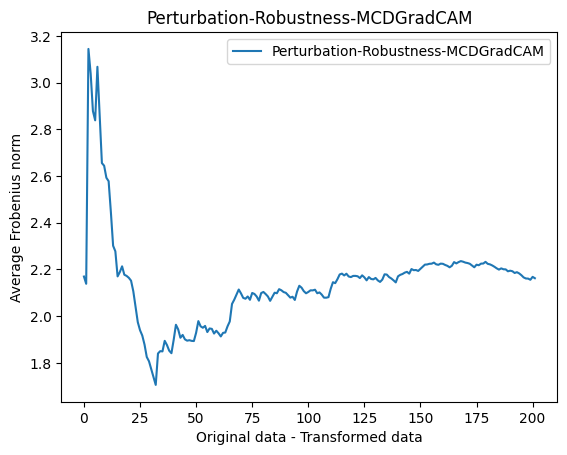

In [ ]:
# 픽셀들을 그래프로 plot하고 불확실성 영역을 표시
plt.figure()

# x축 값 생성 (예시: 0부터 499까지)
x_values = range(len(mc_avg_Frobenius_norm))

# 플롯 생성
plt.figure()
plt.plot(x_values, mc_avg_Frobenius_norm, label='Perturbation-Robustness-MCDGradCAM')

plt.title(f'Perturbation-Robustness-MCDGradCAM')
plt.xlabel('Original data - Transformed data')
plt.ylabel('Average Frobenius norm')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

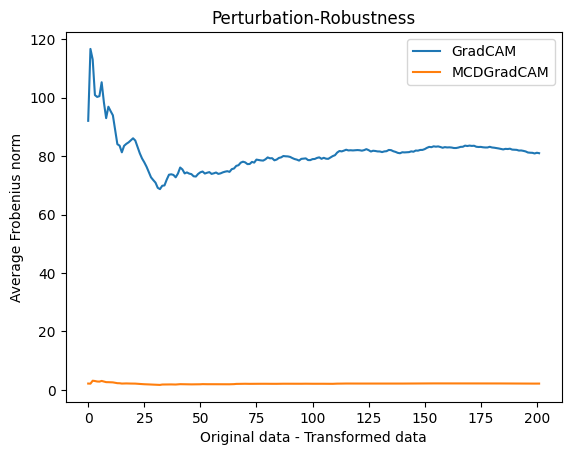

In [ ]:
plt.figure()

x_values = range(len(avg_Frobenius_norm))

plt.figure()
plt.plot(x_values, avg_Frobenius_norm, label='GradCAM')
plt.plot(x_values, mc_avg_Frobenius_norm, label='MCDGradCAM')

plt.title(f'Perturbation-Robustness')
plt.xlabel('Original data - Transformed data')
plt.ylabel('Average Frobenius norm')
plt.legend()
plt.show()

In [ ]:
import gc
# img_tensor = None
# img_tensors = None
# heatmap = None
# predicted_class = None
# fc_dropout_gradcam = None
# result_dict = None
gc.collect()
# with torch.no_grad():
#   torch.cuda.empty_cache()

0

In [ ]:
# mcd_result_dict2["heatmap"] = heatmap.detach().cpu().numpy()
#   mcd_result_dict2["predicted_class"]

In [ ]:
mcd_result_list[1]["cls_entropy"]


0.007907255112232087

In [ ]:
np.shape(mcd_result_list[1]["heatmap"])

(5000, 7, 7)

In [ ]:
np.shape(mcd_result_list[1]["predicted_class"])

(5000,)

In [ ]:
np.shape(mc_grad_cam_mean)

(224, 224, 3)